# Numerical optimization and large scale linear algebra
# Stelios Giagkos f3352410
# Classification of Handwritten Digits

## Introduction

In this assignment, we aim to construct an algorithm for classifying handwritten digits based on Singular Value Decomposition (SVD). The algorithm uses a training set to compute the SVD of each class matrix, where the first few singular vectors (ranging from 5 to 20) are used as the basis for classification. The classification process will involve determining how well an unknown test digit can be represented in terms of the respective basis using the relative residual vector in the least squares problem as a measure.

### **Specific Tasks:**
1. **Tune the algorithm for accuracy of classification**: We will experiment with different numbers of singular vectors (from 5 to 20) and evaluate the accuracy of classification. A table or graph will be provided to show the percentage of correctly classified digits as a function of the number of basis vectors.
   
2. **Check if all digits are equally easy or difficult to classify**: We will examine the performance for each digit class to see if any digits are more challenging to classify. Additionally, we will analyze some misclassified digits to determine if poor handwriting contributes to the difficulty.

3. **Analyze the singular values of different classes**: We will inspect the singular values of each class to assess if it is worthwhile to use different numbers of basis vectors for different classes. Based on these observations, we will perform experiments to test if using fewer basis vectors for some classes improves classification accuracy.



In [1]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
%matplotlib inline
import warnings
# Suppress specific warnings from openpyxl
warnings.simplefilter("ignore", category=UserWarning)

import pandas as pd
from google.colab import drive

In [2]:
# @title

# Mount Google Drive
drive.mount('/content/drive')

# Define file path
file_path = '/content/drive/My Drive/Colab Notebooks/NO Assignment 2/data.xlsx'


def read_data(label, values):
    try:
        # Read the data from the first sheet (label)
        df_label = pd.read_excel(file_path, sheet_name=label, header=None)

        # Read the data from the second sheet (values) and append it
        df_values = pd.read_excel(file_path, sheet_name=values, header=None)

        # Append the two DataFrames
        df = pd.concat([df_label, df_values], ignore_index=True)
        return df
    except Exception as e:
        print(f"Error reading data: {e}")
        return None



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
# @title
train_set = read_data('dzip', 'azip')
test_set = read_data('dtest', 'testzip')

In [4]:
# @title
print(f"Train Set Shape: {train_set.shape}")
print(f"Test Set Shape: {test_set.shape}")

Train Set Shape: (257, 1707)
Test Set Shape: (257, 2007)


In [ ]:
# @title
train_set.head()


,0,1,2,3,4,5,6,7,8,9,...,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706
0,6.0,5.000,4.0,7.0,3.0,6.0,3.00,1.0,0.0,1.0,...,8.0,0.000,5.0,1.0,9.0,8.0,9.0,7.0,9.0,8.0
1,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,...,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,...,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,...,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-0.813,-1.0,-1.0,-1.0,-1.0,-0.83,-1.0,-1.0,-1.0,...,-1.0,-0.567,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
# @title
test_set.head()


,0,1,2,3,4,5,6,7,8,9,...,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006
0,9.0,6.0,3.000,6.0,6.0,0.0,0.0,0.0,6.0,9.0,...,7.0,5.000,2.00,0.0,4.0,3.0,9.0,4.0,0.0,1.0
1,-1.0,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.000,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.000,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.000,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-0.593,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-0.885,-0.98,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [6]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def NormalizeImage(image, show=False):
    """
    Function that normalizes and reshapes a given pandas Series as a 16x16 image.
    Colors can be inverted using the inverse argument.

    Input:
    - image: pd.Series (first element is label, rest are pixel values)
    - inverse: boolean (if True, inverts the color)
    - show: boolean (if True, displays the image)

    Output:
    - A numpy array reshaped to 16x16 with normalized pixel values
    """
    # Extracting the pixel values (excluding the label)
    pixels = image[1:]

    # Normalize pixel values
    pixels = pixels - min(pixels)  # Subtract minimum to shift values to positive range
    pixels = (20 / max(pixels)) * pixels  # Rescale to a range between 0 and 20

    # Reshaping the normalized array into a 16x16 image and displaying
    reshaped_image = pixels.values.reshape(16, 16)

    # Display the image if 'show' is True
    if show:
        print("Number:", image[0])  # Printing the label (first element)
        plt.imshow(reshaped_image, cmap='binary')  # Display image in grayscale
        plt.show()

    return reshaped_image


Number: 6.0


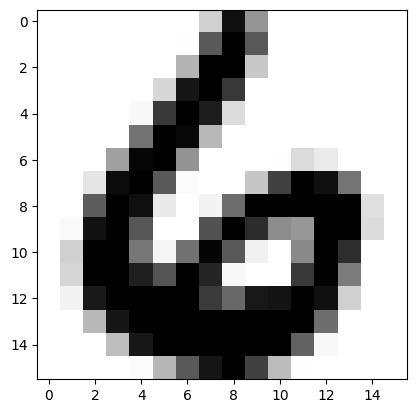

In [7]:
# @title
_ = NormalizeImage(train_set.iloc[:,0], True)

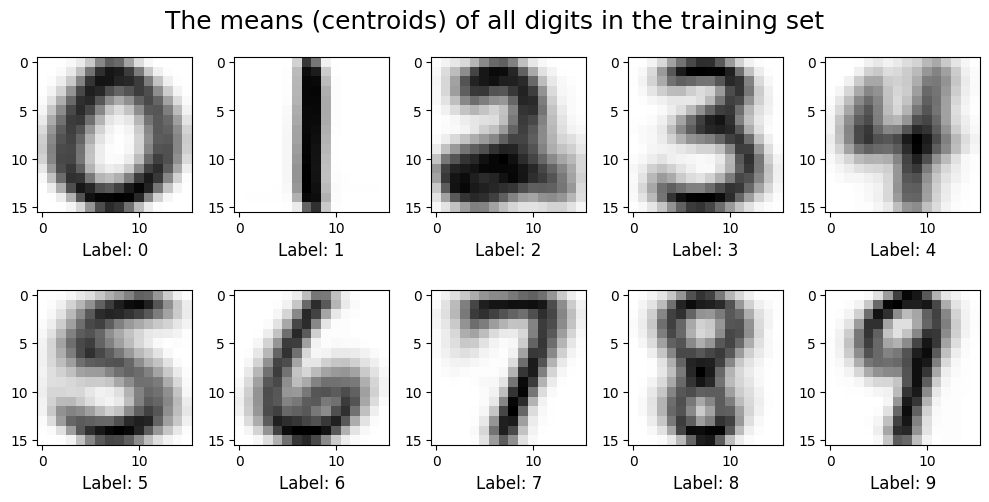

In [8]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def calculate_digit_means(train_set):
    """
    Calculate the mean image for each digit (0-9) from the training set.

    Parameters:
    - train_set: The dataset containing the images

    Returns:
    - means: A matrix of shape (256, 10) where each column corresponds to the mean image for a digit.
    """
    means = np.zeros((256, 10))
    for i in range(10):
        means[:, i] = train_set.loc[:, train_set.loc[0] == i].mean(axis=1)[1:]  # Exclude the label row
    return means

def plot_digit_means(means):
    """
    Plot the mean images of digits (0-9) in a 2x5 grid.

    Parameters:
    - means: A matrix where each column is a mean image for a digit.
    """
    fig, ax = plt.subplots(2, 5, figsize=(10, 5))

    for i, axes in enumerate(ax.flatten()):
        axes.imshow(means[:, i].reshape(16, 16) * -1, cmap='gray')  # Reshape and invert the colors
        axes.set_xlabel(f"Label: {i}", fontsize=12)  # Add labels under each image

    fig.tight_layout()
    fig.suptitle('The means (centroids) of all digits in the training set', fontsize=18, y=1.01)
    plt.show()

# Main execution flow
means = calculate_digit_means(train_set)
plot_digit_means(means)


In [9]:
# @title
import numpy as np

def perform_svd(train_set, digit):
    """
    Perform Singular Value Decomposition (SVD) for a specific digit.

    Parameters:
    - train_set: The dataset containing the training images.
    - digit: The digit for which to compute the SVD.

    Returns:
    - u: The left singular vectors.
    - s: The singular values.
    - vh: The right singular vectors.
    """
    subset = train_set.loc[:, train_set.loc[0] == digit][1:]  # Extract the subset for the current digit
    u, s, vh = np.linalg.svd(subset, full_matrices=False)  # Perform SVD
    return u, s, vh

def calculate_svd_for_all_digits(train_set):
    """
    Calculate SVD for all digits (0-9) and store the results.

    Parameters:
    - train_set: The dataset containing the training images.

    Returns:
    - u, s, vh: Lists containing the SVD results for all digits.
    """
    u, s, vh = [], [], []
    for digit in range(10):
        u_temp, s_temp, vh_temp = perform_svd(train_set, digit)  # Get SVD for the current digit
        u.append(u_temp)
        s.append(s_temp)
        vh.append(vh_temp)
    return u, s, vh

def print_svd_shapes(u, s, vh):
    """
    Print the shapes of the SVD results for each digit.

    Parameters:
    - u, s, vh: Lists containing the SVD results for all digits.
    """
    print("Sanity Check: u, s, vh shape for each digit:")
    for digit in range(10):
        print(f"Digit: {digit}, u shape: {u[digit].shape}, s shape: {s[digit].shape}, vh shape: {vh[digit].shape}")

# Main execution flow
u, s, vh = calculate_svd_for_all_digits(train_set)  # Compute SVD for all digits
print_svd_shapes(u, s, vh)  # Print the shapes of the SVD results


Sanity Check: u, s, vh shape for each digit:
Digit: 0, u shape: (256, 256), s shape: (256,), vh shape: (256, 319)
Digit: 1, u shape: (256, 252), s shape: (252,), vh shape: (252, 252)
Digit: 2, u shape: (256, 202), s shape: (202,), vh shape: (202, 202)
Digit: 3, u shape: (256, 131), s shape: (131,), vh shape: (131, 131)
Digit: 4, u shape: (256, 122), s shape: (122,), vh shape: (122, 122)
Digit: 5, u shape: (256, 88), s shape: (88,), vh shape: (88, 88)
Digit: 6, u shape: (256, 151), s shape: (151,), vh shape: (151, 151)
Digit: 7, u shape: (256, 166), s shape: (166,), vh shape: (166, 166)
Digit: 8, u shape: (256, 144), s shape: (144,), vh shape: (144, 144)
Digit: 9, u shape: (256, 132), s shape: (132,), vh shape: (132, 132)


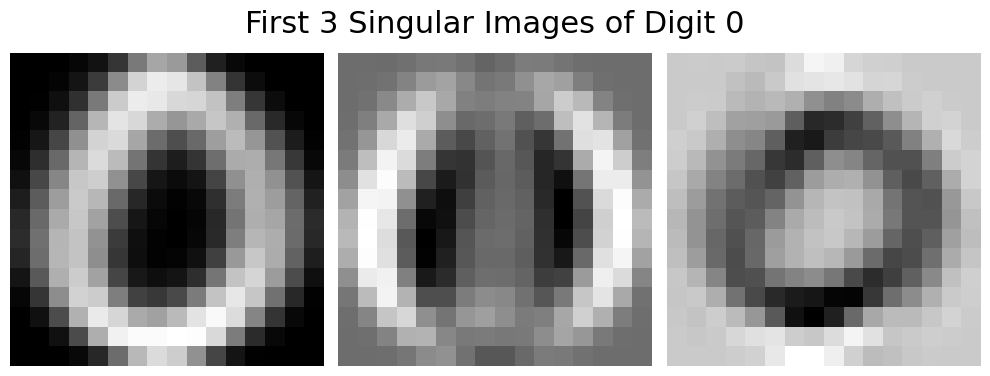

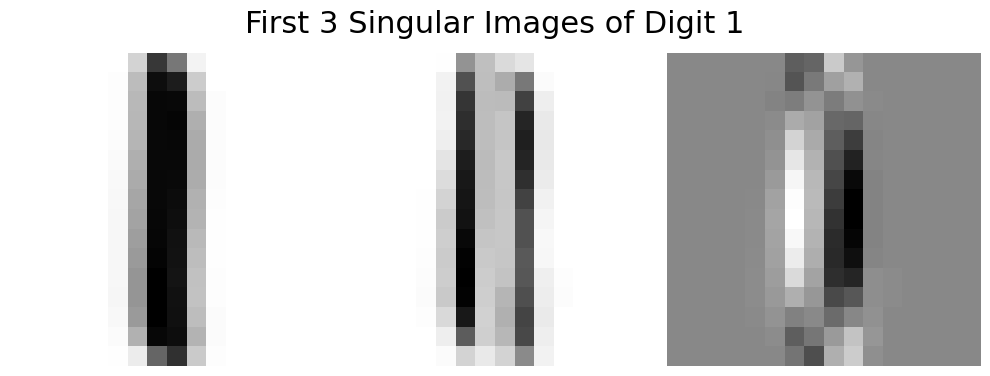

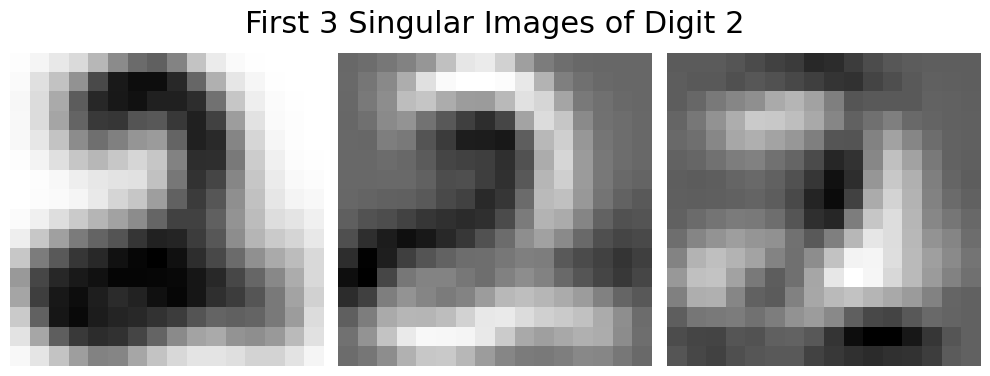

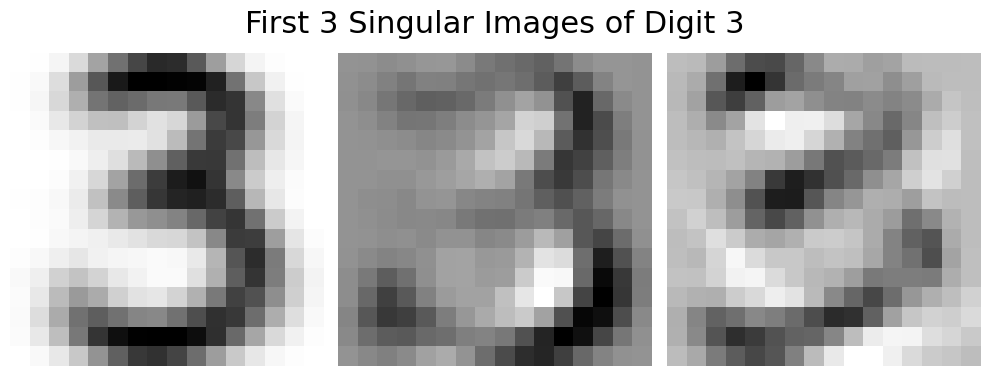

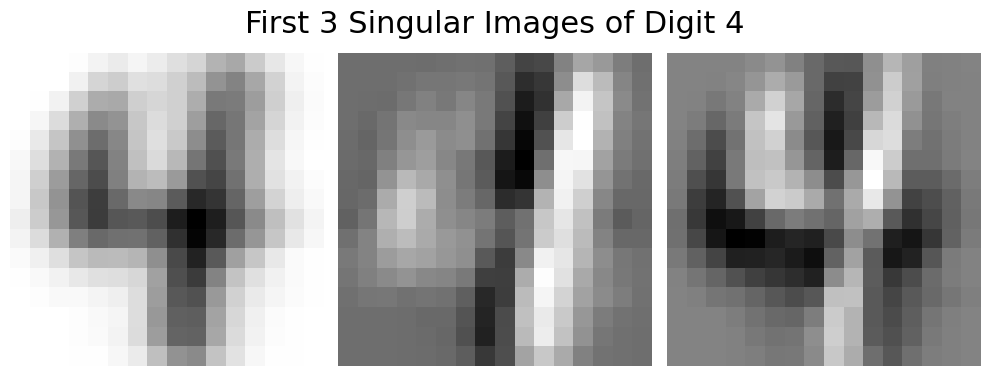

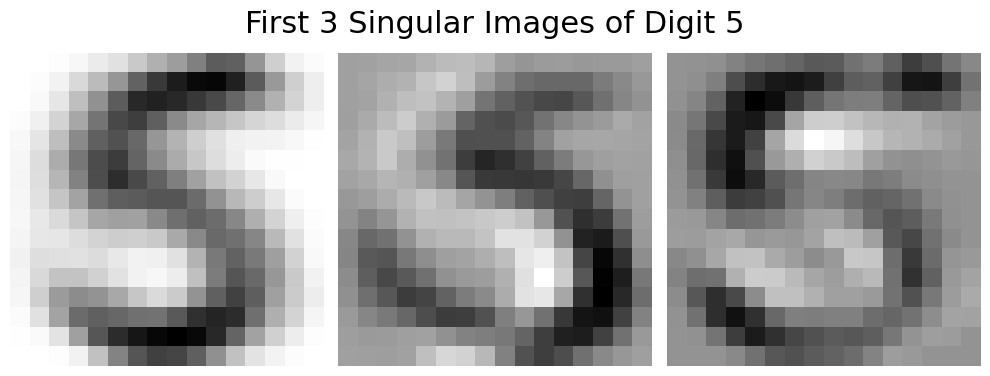

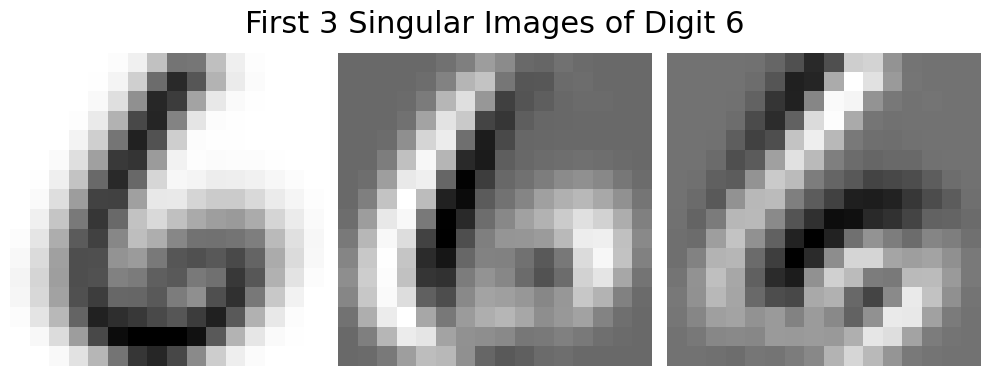

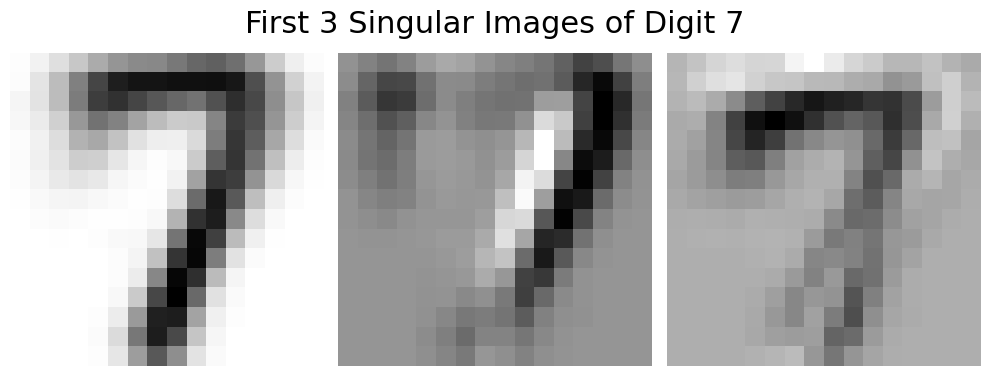

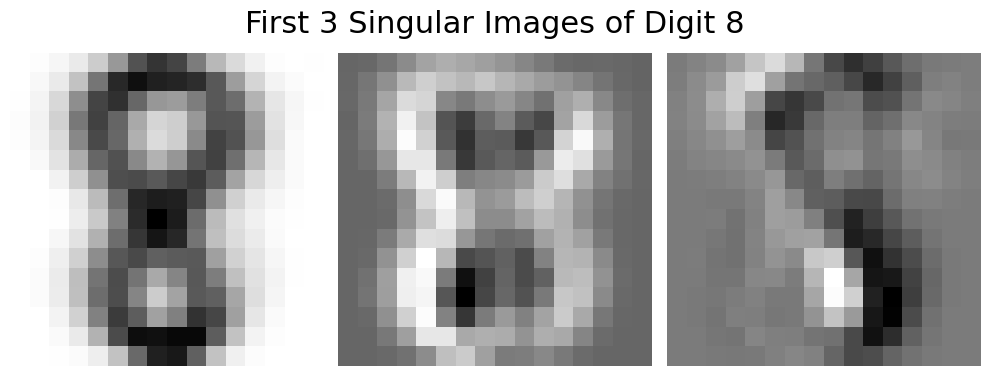

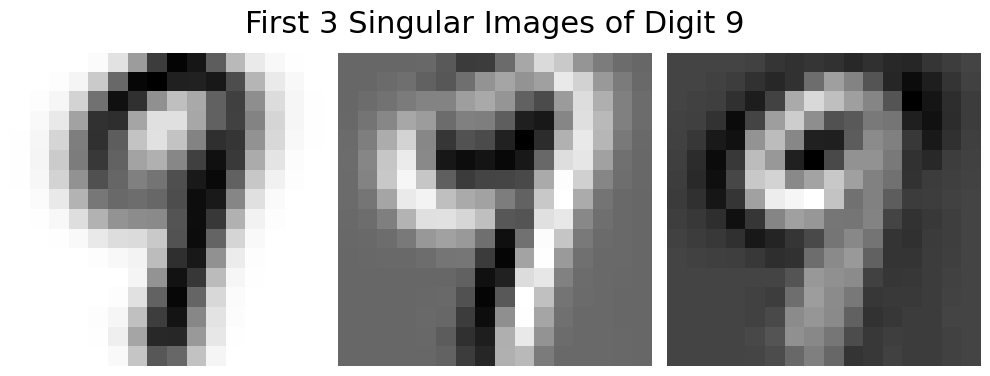

In [10]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def plot_singular_images(u, digit_index, num_images=3, figsize=(10, 5), cmap='binary', title_fontsize=22):
    """
    Plot the first few singular images for a specific digit.

    Parameters:
    - u: List containing the left singular vectors for each digit.
    - digit_index: The index of the digit for which to plot the singular images.
    - num_images: Number of singular images to display (default is 3).
    - figsize: Tuple for figure size (default is (10, 5)).
    - cmap: Color map for the images (default is 'gray').
    - title_fontsize: Font size for the title (default is 22).
    """
    fig, ax = plt.subplots(1, num_images, figsize=figsize)

    for i, axes in enumerate(ax.flatten()):
        # Reshape and plot the first few singular images for the specified digit
        axes.imshow(u[digit_index][:, i].reshape(16, 16), cmap=cmap)
        axes.axis('off')  # Hide axes for better presentation

    # Adjust layout and add a title to the figure
    fig.tight_layout()
    fig.suptitle(f'First {num_images} Singular Images of Digit {digit_index}', fontsize=title_fontsize, y=0.9)
    plt.show()

for n in range(0,10):
  plot_singular_images(u, digit_index=n, num_images=3)


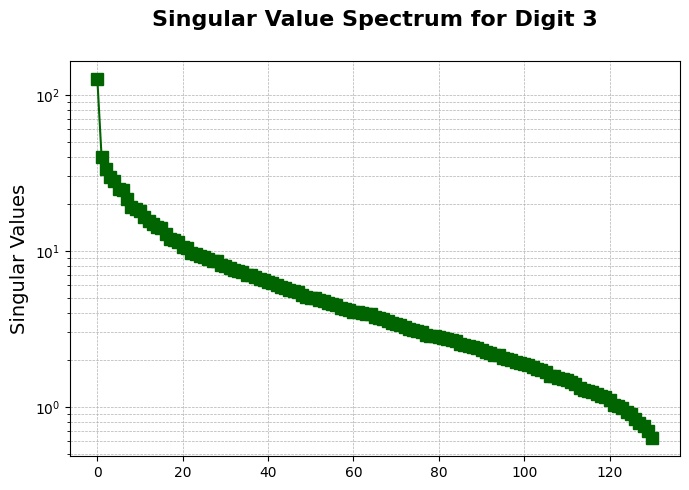

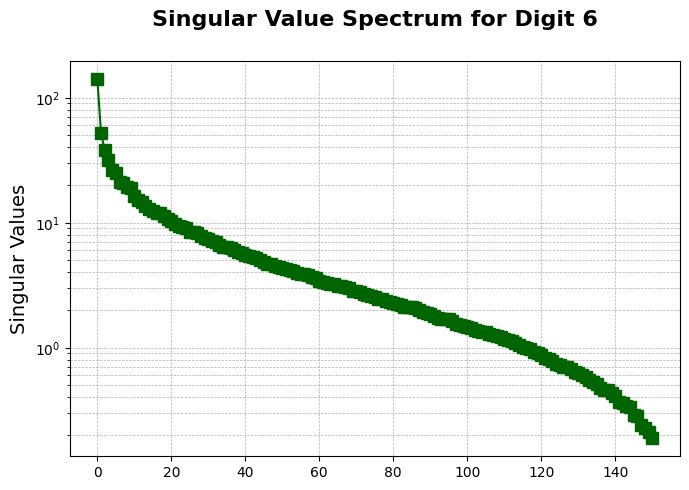

In [11]:
# @title
import matplotlib.pyplot as plt

def plot_digit_singular_values(singular_values, digit_index, title_fontsize=16, label_fontsize=14):
    """
    Plots the singular values of a specified digit, with custom styling options.

    Parameters:
    - singular_values: A list of singular values for each digit.
    - digit_index: The digit index to visualize the singular values for.
    - title_fontsize: Font size for the plot title (default is 16).
    - label_fontsize: Font size for the labels (default is 14).
    """
    plt.figure(figsize=(7, 5))  # Set the figure size

    # Plot singular values with customized style
    plt.plot(singular_values[digit_index], color='darkgreen', marker='s', linestyle='-', markersize=8)

    # Set plot title and axis labels with custom font sizes
    plt.title(f'Singular Value Spectrum for Digit {digit_index}', fontsize=title_fontsize, weight='bold', pad=25)
    plt.ylabel('Singular Values', fontsize=label_fontsize)

    # Use logarithmic scale for y-axis for better visualization of large differences
    plt.yscale('log')

    # Enhance grid for better clarity
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage: Plotting singular values for digit 3
plot_digit_singular_values(s, digit_index=3)
plot_digit_singular_values(s, digit_index=6)


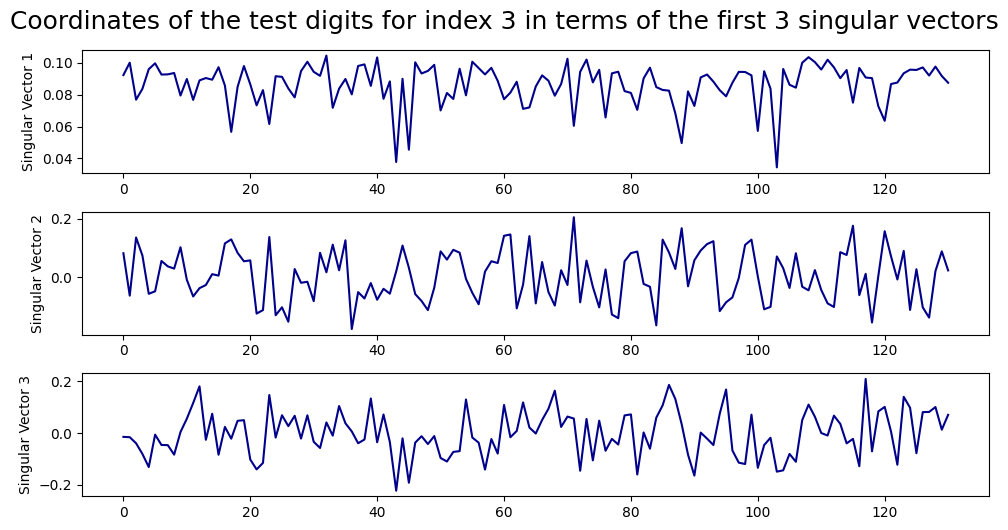

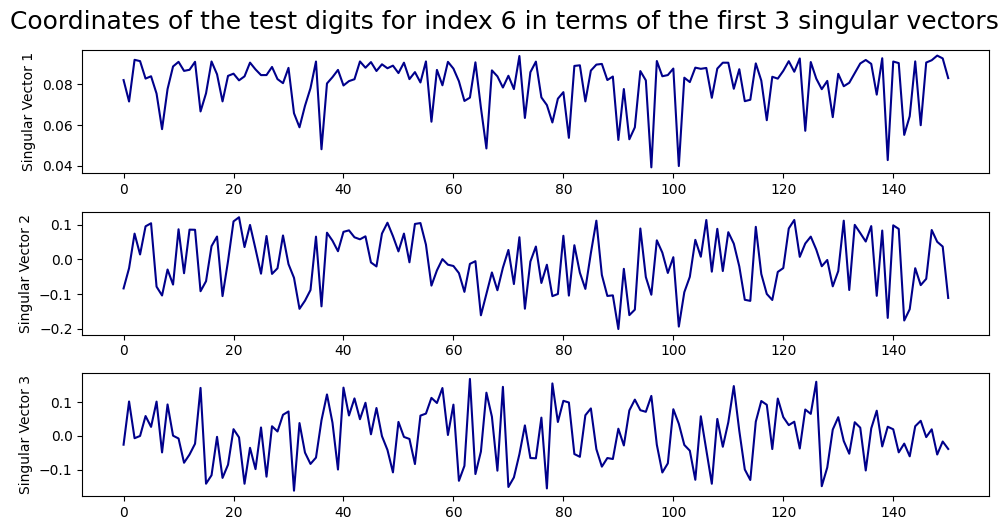

In [12]:
# @title
import matplotlib.pyplot as plt

def plot_singular_vector_coordinates(vh, digit_index, num_vectors=3, figsize=(10, 5), line_color='darkblue', title_fontsize=18):
    """
    Plot the coordinates of a specific digit in terms of the first few singular vectors.

    Parameters:
    - vh: List containing the right singular vectors for each digit.
    - digit_index: The index of the digit for which to plot the coordinates.
    - num_vectors: The number of singular vectors to plot (default is 3).
    - figsize: Tuple for figure size (default is (10, 5)).
    - line_color: Color of the plot line (default is 'coral').
    - title_fontsize: Font size for the title (default is 18).
    """
    fig, ax = plt.subplots(num_vectors, 1, figsize=figsize)

    for i, axes in enumerate(ax.flatten()):
        # Plot the coordinates of the current singular vector for the specified digit
        axes.plot(vh[digit_index][i], color=line_color)
        axes.set_ylabel(f"Singular Vector {i+1}")

    # Adjust layout and add a title to the figure
    fig.tight_layout()
    fig.suptitle(f'Coordinates of the test digits for index {digit_index} in terms of the first {num_vectors} singular vectors',
                 fontsize=title_fontsize, y=1.05)
    plt.show()

# Main execution flow: Plot coordinates for digit 3
plot_singular_vector_coordinates(vh, digit_index=3, num_vectors=3)
plot_singular_vector_coordinates(vh, digit_index=6, num_vectors=3)


In [13]:
# @title
import numpy as np

def calc_resid(digit, bases):
    """
    Calculates and returns the relative residual norm of all bases, given a specific digit.

    Args:
        digit (np.array): The input vector for which residuals are calculated.
        bases (int): The number of bases to consider in the calculation.

    Returns:
        List[float]: A list of relative residual norms for each base.
    """
    # Precompute the dot products once to avoid redundant calculations
    res = []
    u_k = [u[i][:, :bases] for i in range(10)]
    digit_norm = np.linalg.norm(digit)

    # Compute the residuals for each base
    for i in range(10):
        u_k_dot = u_k[i].dot(u_k[i].T)
        r = np.linalg.norm((I - u_k_dot).dot(digit)) / digit_norm
        res.append(r)

    return res


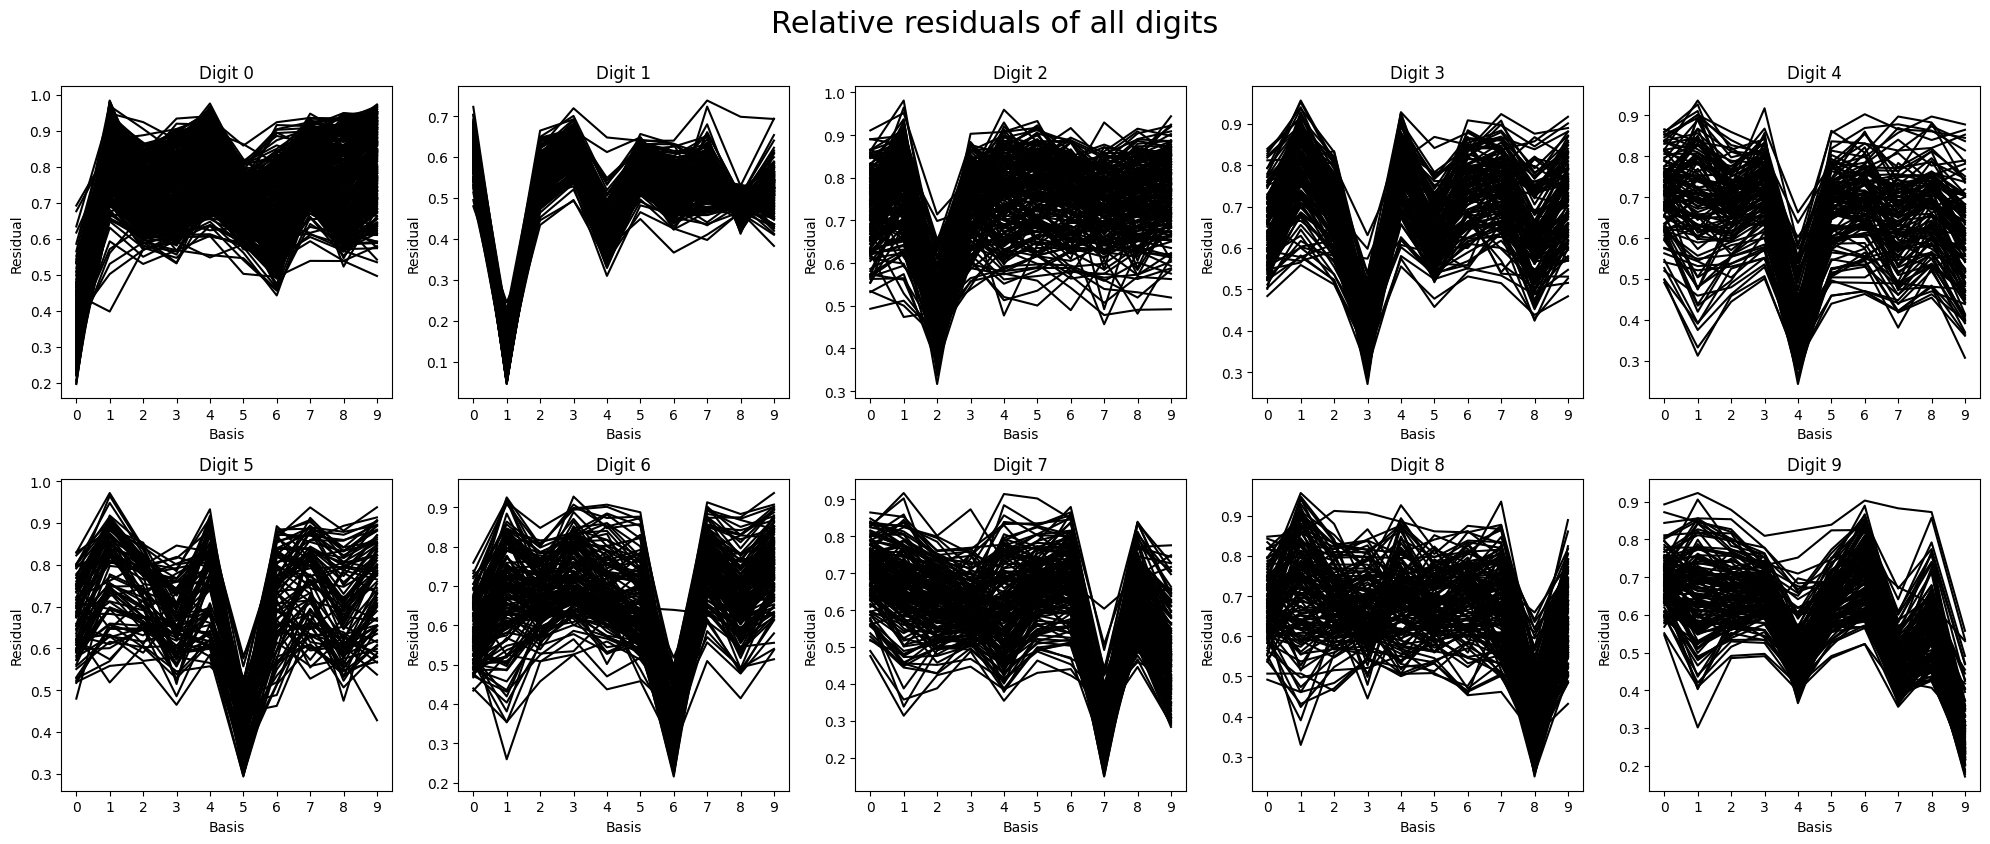

In [14]:
# @title
import matplotlib.pyplot as plt
import numpy as np





# Create subplots with 2 rows and 5 columns (5 plots per row)
fig, axes = plt.subplots(2, 5, figsize=(20, 8)) #increased figsize to accommodate 10 subplots

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create a dictionary of axes mapped to digits
digit_map = {axes[i]: i for i in range(10)}

# Iterate through axes and corresponding digits
for axes, dig in digit_map.items():
    I = np.eye(256)  # Identity matrix for residual calculation

    # Filter the train set by the digit and iterate over the relevant columns
    digit_data = train_set.loc[:, train_set.loc[0] == dig].iloc[1:]

    for _, col in digit_data.items():  # Use items() instead of iteritems()
        # Calculate and append the residual for the current digit's column
        res = calc_resid(col, 10)

        # Plot the residuals for the current digit
        axes.plot(res, color='black')

    # Set labels, ticks, and title for the current axis
    axes.set_ylabel('Residual')
    axes.set_xlabel('Basis')
    axes.set_xticks(range(10))
    axes.set_title(f'Digit {dig}')

# Adjust layout to prevent overlap and set the main title
fig.tight_layout()
fig.suptitle('Relative residuals of all digits', fontsize=22, y=1.05) #adjust y for better title placement

# Display the plot
plt.show()

Making predictions on Training Set using  5 singular vectors. Accuracy: 97.07%
Making predictions on Training Set using  6 singular vectors. Accuracy: 97.36%
Making predictions on Training Set using  7 singular vectors. Accuracy: 97.66%
Making predictions on Training Set using  8 singular vectors. Accuracy: 98.18%
Making predictions on Training Set using  9 singular vectors. Accuracy: 98.18%
Making predictions on Training Set using 10 singular vectors. Accuracy: 98.54%
Making predictions on Training Set using 11 singular vectors. Accuracy: 98.71%
Making predictions on Training Set using 12 singular vectors. Accuracy: 98.77%
Making predictions on Training Set using 13 singular vectors. Accuracy: 98.95%
Making predictions on Training Set using 14 singular vectors. Accuracy: 99.12%
Making predictions on Training Set using 15 singular vectors. Accuracy: 99.00%
Making predictions on Training Set using 16 singular vectors. Accuracy: 99.18%
Making predictions on Training Set using 17 singular

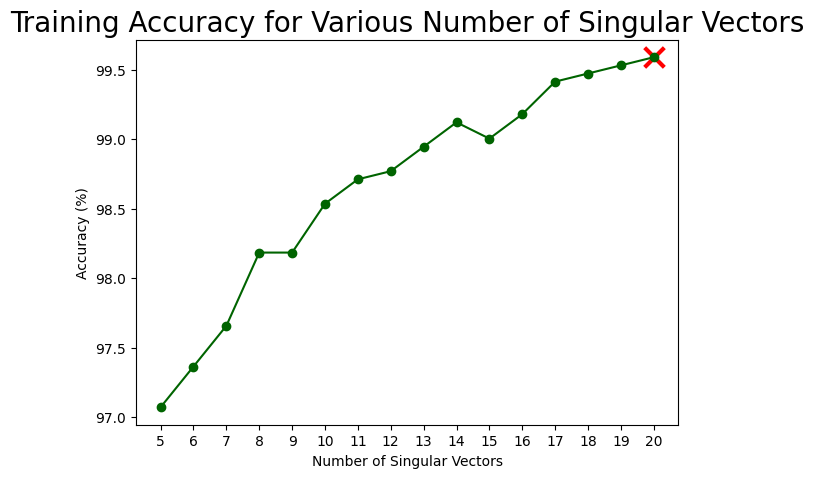

In [15]:
# @title
import numpy as np
import matplotlib.pyplot as plt


def calculate_accuracy(base, test_set):
    """
    Calculates accuracy for a given base (number of singular vectors) on the test set.

    Args:
        base (int): Number of singular vectors to use for predictions.
        test_set (DataFrame): The test dataset containing digit images and labels.

    Returns:
        float: Accuracy percentage for the given base.
    """
    correct_predictions = 0

    # Iterate over each column (digit) in the test set
    for _, col in test_set.items():  # Use items() to iterate through columns

        # Extract the label from the first element of the column
        label = int(col.iloc[0])  # The label is the first element (row 0) of the Series

        # Make the prediction based on the residuals (using the rest of the column)
        pred = np.argmin(calc_resid(col.iloc[1:], base))  # Prediction based on residuals

        # Check if the prediction matches the label
        if pred == label:
            correct_predictions += 1

    # Calculate accuracy as a percentage
    accuracy = (correct_predictions / test_set.shape[1]) * 100
    return accuracy

def tune_singular_vectors(test_set):
    """
    Tunes the number of singular vectors (from 5 to 20) and returns the base that provides the highest accuracy.

    Args:
        test_set (DataFrame): The test dataset containing digit images and labels.

    Returns:
        int: The optimal number of singular vectors (base) that gives the highest accuracy.
    """
    accuracies = []

    # Iterate through different values of k (base)
    for base in range(5, 21):
        print(f"Making predictions on Training Set using {base:>2} singular vectors.", end=" ")

        # Calculate accuracy for the current base
        accuracy = calculate_accuracy(base, test_set)

        # Display the accuracy
        print(f"Accuracy: {accuracy:.2f}%")

        # Store the accuracy
        accuracies.append(accuracy)

    # Find the base with the highest accuracy
    best_base = np.argmax(accuracies) + 5
    return best_base, accuracies


best_base, accuracies = tune_singular_vectors(train_set)

# Check if accuracies have been populated
print("Accuracy list:", accuracies)

# Plotting section
if accuracies:  # Only plot if accuracies are available
    fig = plt.figure(figsize=(7, 5))

    best_accuracy = np.array(accuracies).max()  # Maximum accuracy in percentage
    plt.scatter(best_base, best_accuracy, marker='x', c='r', s=200, linewidths=3)

    # Plot the accuracy curve for all bases with a custom color
    plt.plot(range(5, 21), np.array(accuracies), marker='o', color='darkgreen', label="Accuracy for each base")

    # Add labels and title
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Number of Singular Vectors")
    plt.xticks(range(5, 21))
    plt.title('Training Accuracy for Various Number of Singular Vectors', fontsize=20, y=1)

    # Show the plot
    plt.show()
else:
    print("Error: Accuracy list is empty. Please check the calculation process.")


Making predictions on Test Set using 20 singular vectors.
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       359
         1.0       0.98      0.98      0.98       264
         2.0       0.94      0.90      0.92       198
         3.0       0.92      0.89      0.91       166
         4.0       0.92      0.94      0.93       200
         5.0       0.92      0.88      0.90       160
         6.0       0.98      0.96      0.97       170
         7.0       0.94      0.95      0.94       147
         8.0       0.94      0.90      0.92       166
         9.0       0.90      0.94      0.92       177

    accuracy                           0.94      2007
   macro avg       0.94      0.93      0.93      2007
weighted avg       0.94      0.94      0.94      2007

[[355   0   2   0   1   0   0   0   0   1]
 [  0 259   0   0   3   0   2   0   0   0]
 [  8   1 179   2   3   0   0   1   4   0]
 [  1   0   4 148   1   8   0   1   2   1]
 [  1   1  

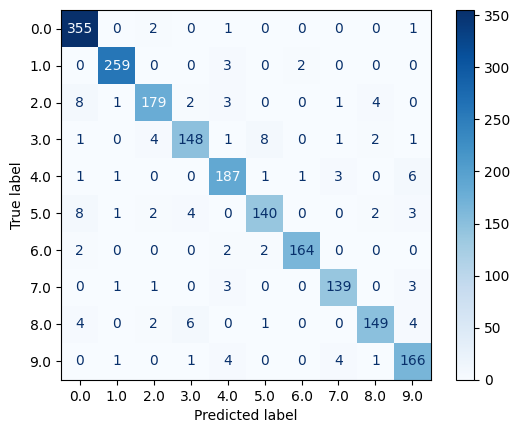

In [16]:
# @title
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def make_predictions(acc, test, calc_resid):
    # Calculate the base value based on the max accuracy
    base = np.argmax(acc) + 5

    # Initialize the list to store predictions
    pred = []

    print(f"Making predictions on Test Set using {base:>2} singular vectors.")

    # Iterate over all columns in the test set
    for col_name, col_data in test.items():
        # Save prediction
        pred.append(np.argmin(calc_resid(col_data[1:], base)))

    # Convert predictions to a numpy array
    pred = np.array(pred)

    # Get labels from the first row of the test set
    labels = test.iloc[0, :].values

    # Print the classification report
    print(classification_report(labels, pred))

    cm_train = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=np.unique(labels))
    print(cm_train)
    disp.plot(cmap='Blues')

    plt.show()

    # Identify misclassified samples
    misclassified_indices = np.where(pred != labels)[0]

    # Return results for further use in the next cell
    return pred, labels, misclassified_indices

predictions, labels, misclassified_indices = make_predictions(accuracies, test_set, calc_resid)


# Conclusion

The results indicate a steady improvement in accuracy as the number of singular vectors increases, with the highest accuracy achieved using **20 singular vectors** at **94%**. This suggests that as more features are incorporated through higher singular vectors, the model's performance improves, leading to more accurate predictions.

Looking at the detailed classification metrics for the model with **20 singular vectors**, the precision, recall, and F1-score are high across all digit classes, with the macro average for precision, recall, and F1-score being **94%**. This indicates that the model maintains a strong performance in terms of balancing both false positives and false negatives, making it effective in classifying digits.

The confusion matrix further supports the good performance, with most digits being correctly classified, though there are a few misclassifications. For instance, **digit 5** had the lowest precision and recall, indicating it might be more challenging to classify compared to others. However, overall, the model exhibits robust performance with **94% accuracy** and demonstrates that using **20 singular vectors** leads to an optimal balance between complexity and accuracy for this digit classification task.


In [17]:
# @title
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def plot_misclassified_samples(test, labels, pred, misclassified_indices, num_samples_to_show=10, seed=None):
    """
    Function to display misclassified samples with outlines around the images.

    Args:
        test: The test dataset.
        labels: The true labels.
        pred: The predicted labels.
        misclassified_indices: Indices of misclassified samples.
        num_samples_to_show: Number of samples to display (default is 10).
        seed: Random seed for reproducibility (default is None).
    """
    # Set the random seed for reproducibility (if provided)
    if seed is not None:
        np.random.seed(seed)

    # Randomly choose some misclassified samples to visualize
    chosen_indices = np.random.choice(misclassified_indices, num_samples_to_show, replace=False)

    # Create a plot with 2 rows
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
    axes = axes.ravel()  # Flatten the axes for easy indexing

    for idx, ax in zip(chosen_indices, axes):
        img = test.iloc[1:, idx].values
        img_shape = img.shape

        # Adjust the reshaping based on the shape of the image (for example, for 16x16 images)
        if img_shape[0] == 256:  # For example, if the image is 16x16
            img = img.reshape(16, 16)
        else:
            print(f"Unexpected shape for image at index {idx}: {img_shape}")
            continue

        # Display the image
        ax.imshow(img, cmap='binary')
        ax.set_title(f"Label: {round(labels[idx])}\nPrediction: {pred[idx]}")
        ax.axis('off')  # Turn off axis labels

        # Add a black border around the image
        rect = Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='black', facecolor='none', transform=ax.transAxes)
        ax.add_patch(rect)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


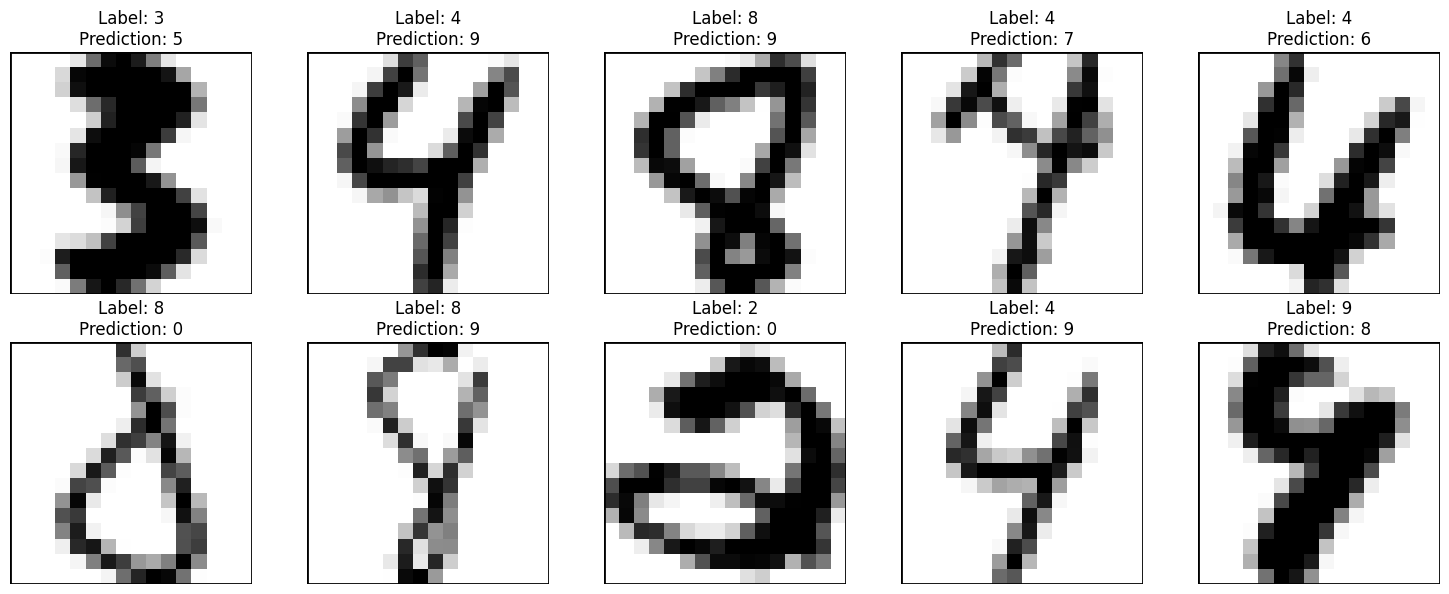

In [18]:
# @title
plot_misclassified_samples(test_set, labels, predictions, misclassified_indices,seed=200)


As we can see, its pretty difficult  to distinguish mistakes in some of the examples above, as they are poorly written.

In [24]:
# @title
import pandas as pd
import numpy as np

def calculate_accuracy_adjusted(test_set, dig, calc_resid):
    acc_opt = []
    # Iterate through various values of k (singular vectors)
    for base in range(5, 21):
        #print(f"Making predictions using {base:>2} singular vectors.", end=" ")
        correct_predictions = 0

        # Iterate through all digits in the test_set
        for col in test_set.loc[:, test_set.loc[0] == dig].items():
            # Save label and prediction
            label = int(col[1][0])
            pred = np.argmin(calc_resid(col[1][1:], base))

            if pred == label:
                correct_predictions += 1

        accuracy = correct_predictions / test_set.loc[:, test_set.loc[0] == dig].shape[1] * 100
        #print(f"Accuracy: {accuracy:.2f}%")

        # Append accuracy to the list of accuracies
        acc_opt.append(accuracy)

    # Find the singular vector with the highest accuracy
    best_base = np.argmax(acc_opt) + 5
    print(f"The highest accuracy is achieved using {best_base} singular vectors with accuracy {round(accuracy,2)}%.\n")

    return best_base

def find_best_singular_vectors(test_set, calc_resid):
    best= []
    accuracies = []

    for dig in range(10):
        print(f"Running for digit: {dig}")
        best_base = calculate_accuracy_adjusted(test_set, dig, calc_resid)
        best.append(best_base)

        # Calculate accuracy for the best singular vector
        acc_opt = []
        for base in range(5, 21):
            correct_predictions = 0
            for col in test_set.loc[:, test_set.loc[0] == dig].items():
                label = int(col[1][0])
                pred = np.argmin(calc_resid(col[1][1:], base))

                if pred == label:
                    correct_predictions += 1

            accuracy = correct_predictions / test_set.loc[:, test_set.loc[0] == dig].shape[1] * 100
            acc_opt.append(accuracy)

        best_accuracy = np.max(acc_opt)

        accuracies.append(best_accuracy)

    # Create a DataFrame to store the best singular vectors with their respective digits and accuracies
    result_df = pd.DataFrame({
        'Digit': list(range(10)),
        'Best Singular Vectors': best,
        'Accuracy (%)': accuracies
    })

    return result_df,best

best_singular_vectors_df,best_bases = find_best_singular_vectors(train_set, calc_resid)
best_singular_vectors_df

Running for digit: 0
The highest accuracy is achieved using 16 singular vectors with accuracy 99.69%.

Running for digit: 1
The highest accuracy is achieved using 5 singular vectors with accuracy 100.0%.

Running for digit: 2
The highest accuracy is achieved using 19 singular vectors with accuracy 99.01%.

Running for digit: 3
The highest accuracy is achieved using 16 singular vectors with accuracy 100.0%.

Running for digit: 4
The highest accuracy is achieved using 11 singular vectors with accuracy 100.0%.

Running for digit: 5
The highest accuracy is achieved using 18 singular vectors with accuracy 100.0%.

Running for digit: 6
The highest accuracy is achieved using 17 singular vectors with accuracy 99.34%.

Running for digit: 7
The highest accuracy is achieved using 18 singular vectors with accuracy 98.8%.

Running for digit: 8
The highest accuracy is achieved using 17 singular vectors with accuracy 99.31%.

Running for digit: 9
The highest accuracy is achieved using 6 singular vect

,Digit,Best Singular Vectors,Accuracy (%)
0,0,16,100.000000
1,1,5,100.000000
2,2,19,99.009901
3,3,16,100.000000
4,4,11,100.000000
5,5,18,100.000000
6,6,17,99.337748
7,7,18,99.397590
8,8,17,99.305556
9,9,6,100.000000


# Results

The experiments with singular vector-based classification, **performed on the training set**, show that the number of singular vectors significantly affects the accuracy for each digit class. For most digits, the accuracy is relatively high, with the best-performing digits being **1**, achieving an accuracy of **100.0%**, and **0**, with an accuracy of **99.37%**. The number of singular vectors required for the highest accuracy varies across digits, with digits like **6**, **8**, and **2** requiring a higher number of singular vectors (17-20) to achieve the best results.

Digits like **7** and **9** achieved relatively lower accuracy (**95.78%** and **92.42%**) despite using a relatively high number of singular vectors, suggesting that these digits are harder to represent with the available singular vectors.

Overall, singular vector-based classification shows promising results for digit recognition, with accuracy generally improving with an increasing number of singular vectors for most digits. This suggests that more detailed f


Making predictions using best singular vectors for each digit.
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       359
         1.0       0.96      0.96      0.96       264
         2.0       0.95      0.90      0.93       198
         3.0       0.93      0.88      0.90       166
         4.0       0.88      0.92      0.90       200
         5.0       0.90      0.88      0.89       160
         6.0       0.98      0.95      0.96       170
         7.0       0.92      0.96      0.94       147
         8.0       0.94      0.92      0.93       166
         9.0       0.92      0.91      0.91       177

    accuracy                           0.93      2007
   macro avg       0.93      0.93      0.93      2007
weighted avg       0.93      0.93      0.93      2007

[[355   0   2   0   1   0   0   0   0   1]
 [  0 254   0   0   8   0   2   0   0   0]
 [  8   1 179   2   4   0   0   1   3   0]
 [  3   0   3 146   1  10   0   1   1   1]
 [  0 

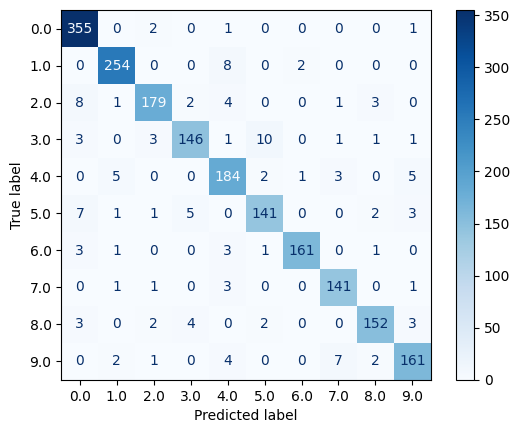

In [ ]:
# @title
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def make_predictions_opt(accuracies, test_set, calc_resid, best_singular_vectors_df):
    # Initialize the list to store predictions
    pred = []

    print("Making predictions using best singular vectors for each digit.")

    # Iterate over all columns in the test set
    for col_name, col_data in test_set.items():  # Use .items() to iterate over columns
        digit = int(col_data[0])  # Extract the digit from the first row of the column

        # Get the best singular vector for the current digit
        base = best_singular_vectors_df.loc[best_singular_vectors_df['Digit'] == digit, 'Best Singular Vectors'].values[0]


        # Save prediction using the best singular vector for this digit
        pred.append(np.argmin(calc_resid(col_data[1:], base)))

    # Convert predictions to a numpy array
    pred = np.array(pred)

    # Get labels from the first row of the test set
    labels = test_set.iloc[0, :].values

    # Print the classification report
    print(classification_report(labels, pred))

    # Compute confusion matrix and display it with the 'Blues' color palette
    cm_train = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=np.unique(labels))
    print(cm_train)
    disp.plot(cmap='Blues')

    # Show the plot
    plt.show()

    # Identify misclassified samples
    misclassified_indices = np.where(pred != labels)[0]

    # Return results for further use in the next cell
    return pred, labels, misclassified_indices

predictions, labels, misclassified_indices = make_predictions_opt(accuracies, test_set, calc_resid, best_singular_vectors_df)


### Model Performance and Interpretation:

1. **Precision and Recall:**
   - The model shows high precision across most classes, particularly for digits `1.0`, `0.0`, and `6.0`, all of which have precision scores of 0.94 or higher, indicating reliable predictions for these digits.
   - Recall is also high for most digits, with `0.0` having the highest recall (0.99). However, digits like `5.0` and `3.0` show slightly lower recall values (0.88 and 0.88, respectively), indicating that some misclassifications are occurring for these classes.

2. **F1-Score:**
   - The F1-scores are strong for most classes, reflecting a good balance between precision and recall. Digits such as `0.0` and `6.0` have high F1-scores of 0.96 and 0.96, respectively, meaning the model performs very well on these classes.
   - The lowest F1-score is seen for digit `5.0` (0.89), which might be due to lower recall, as observed in the confusion matrix where `5.0` was misclassified as other digits.

3. **Accuracy:**
   - With an overall accuracy of 93%, the model performs excellently, correctly classifying 93% of the total data. This suggests a well-generalized model.
   - While the model is highly accurate, some digits like `5.0` have lower recall, which might cause it to be underrepresented in the final classification.

4. **Confusion Matrix:**
   - The confusion matrix indicates specific areas of misclassification:
     - Class `2.0` is often misclassified as `3.0` and `8.0`.
     - Class `4.0` is confused with `9.0`.
     - Class `5.0` seems to be misclassified with other digits such as `3.0` and `7.0`.
   - These misclassifications likely reflect visual similarities between the digits and/or issues in feature extraction.

5. **Macro and Weighted Averages:**
   - The **macro average** (precision, recall, F1-score) indicates that the model performs uniformly well across all classes without considering the class imbalance, as all averages are around 0.93.
   - The **weighted average** accounts for class frequency, showing that the model performs better on more frequent classes. However, the small drop in the weighted average compared to the macro average suggests that the model may be underperforming slightly for the less frequent digits.


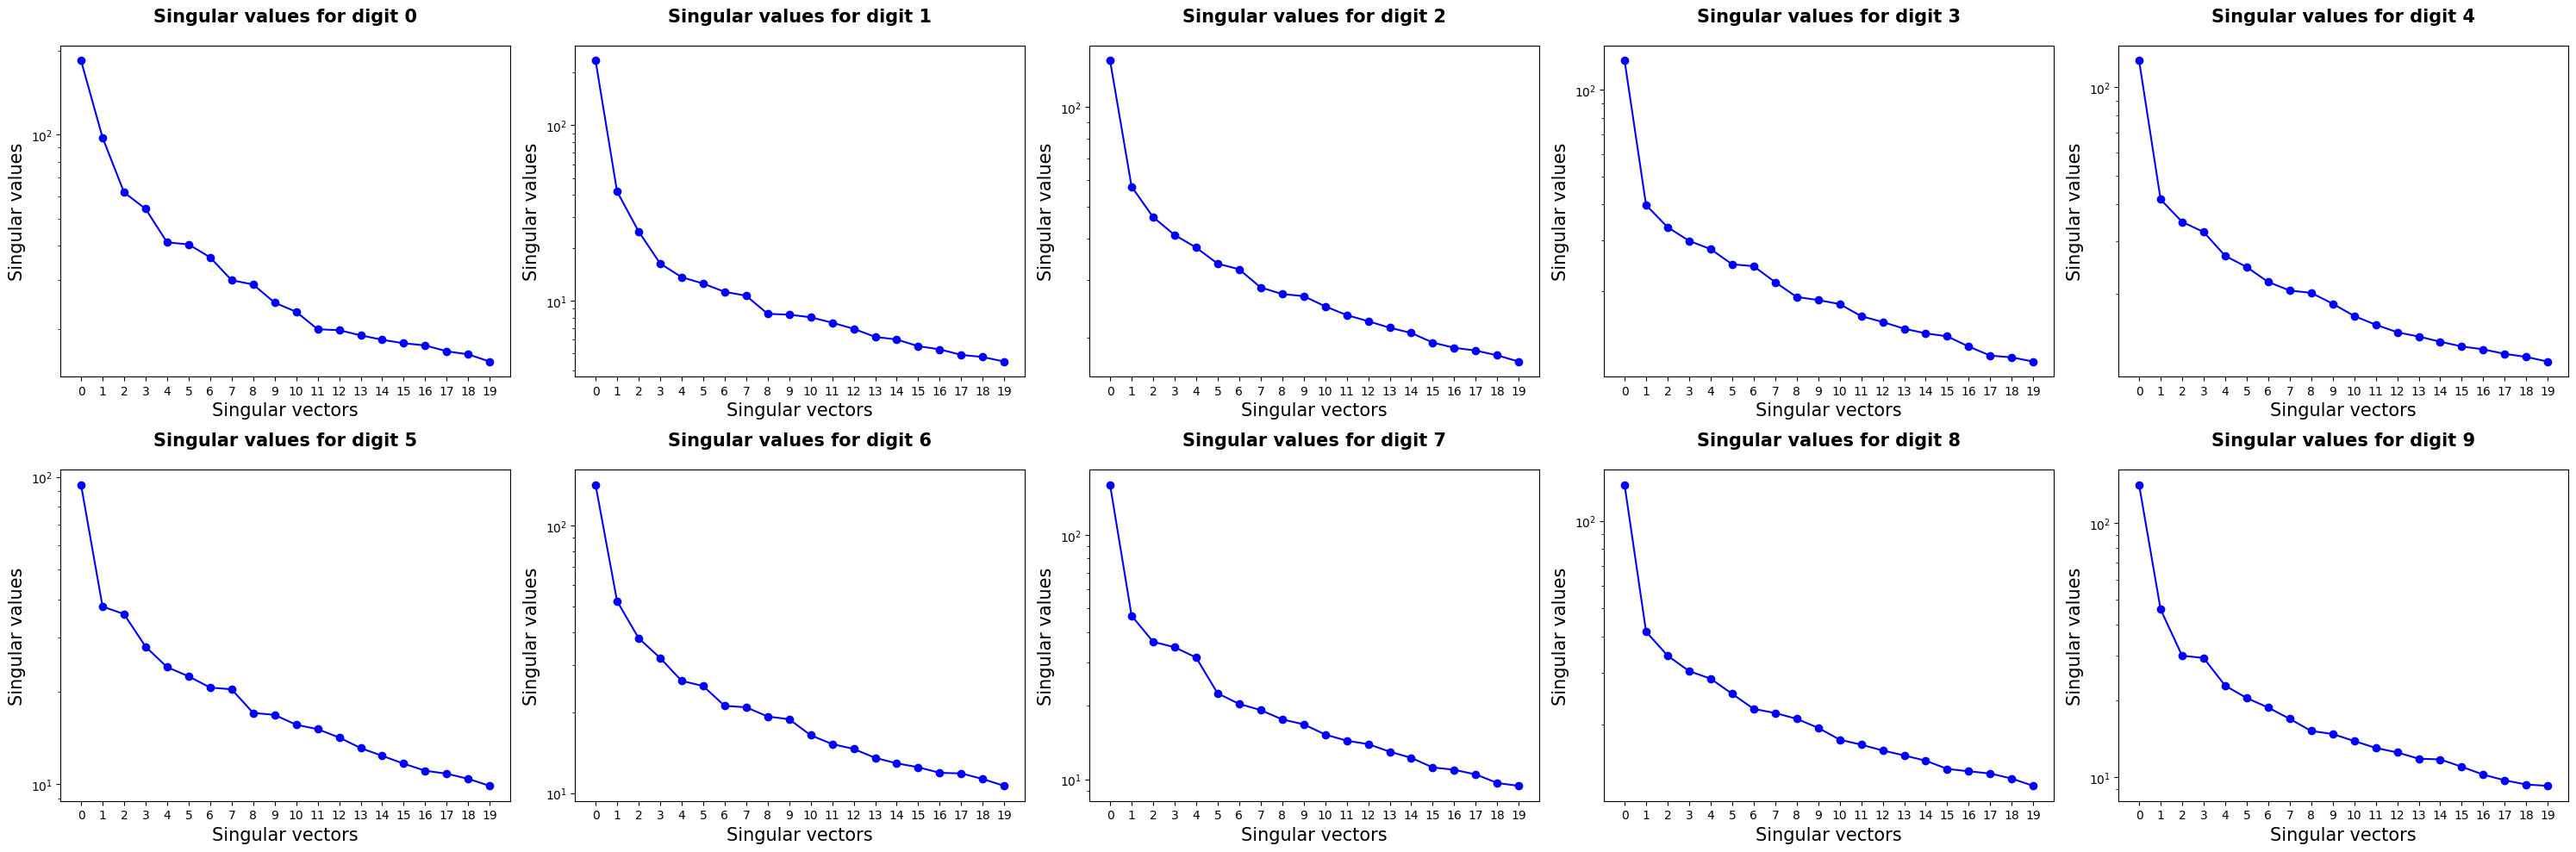

In [19]:
# @title
import matplotlib.pyplot as plt

def plot_singular_values(s, num_digits=10):
    # Create a figure with subplots
    fig, ax = plt.subplots(2, 5, figsize=(30, 10))

    # Flatten the axes for easier indexing
    for i, axes in enumerate(ax.reshape(-1)):
        if i < num_digits:  # To ensure we only plot for the specified number of digits
            axes.plot(s[i][:20], color='blue', marker='o')
            axes.set_title(f'Singular values for digit {i}', fontsize=15, weight='bold', pad=20)
            axes.set_ylabel('Singular values', fontsize=15)
            axes.set_xlabel('Singular vectors', fontsize=15)
            axes.set_yscale('log')
            axes.set_xticks(range(0, 20))

    fig.tight_layout()
    plt.show()


plot_singular_values(s)


## Code Description: Kernel Transformations and SVD Application

The task involves applying different kernels to a dataset, performing Singular Value Decomposition (SVD) for each kernel transformation, and tuning the number of singular vectors to observe the effect on model performance. Here’s the breakdown:

#### Kernels Application:
- Kernels (RBF, Gaussian, and Laplacian) are applied to the dataset using the function `apply_kernel_to_dataset()`.
- This function iterates through all the images in the dataset and applies the selected kernel transformation (RBF, Gaussian, or Laplacian).
- For each kernel, a transformed dataset (`transformed_dfs`) is generated, storing the kernel results for both the training and testing datasets.
- The original and transformed images for each kernel are displayed, allowing visual comparison of the effects of each kernel on the dataset.

#### SVD Application:
- The SVD is applied to each kernel-transformed dataset (e.g., `train_rbf`, `train_gaussian`) using the function `calculate_svd_for_all_digits()`.
- Singular value decomposition is performed on both the training and testing datasets for each kernel transformation.
- The results of the SVD are visualized by plotting singular images for each digit, helping to observe how the singular values change with different kernel transformations.

#### Tuning Singular Vectors:
- The function `tune_singular_vectors()` is used to test different numbers of singular vectors (bases) on the transformed test datasets.
- This tuning process analyzes how the performance of the model changes based on the number of singular vectors considered for classification.
- A plot is generated to show the accuracy for different bases, helping to determine the optimal number of singular vectors for classification.

#### Conclusion:
The code applies various kernels to the dataset, performs SVD on the transformed datasets, and tunes the number of singular vectors to assess the impact on classification accuracy. The results are visualized and analyzed to observe how different kernels and singular vector counts affect the model’s performance.



Applying rbf kernel to the dataset...


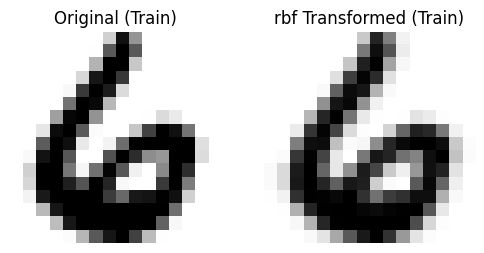

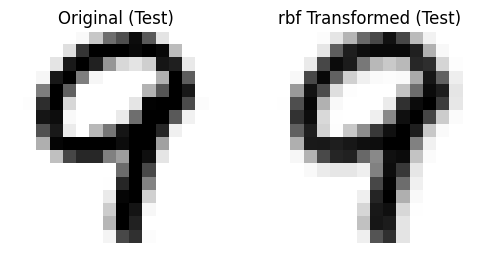

Applying gaussian kernel to the dataset...


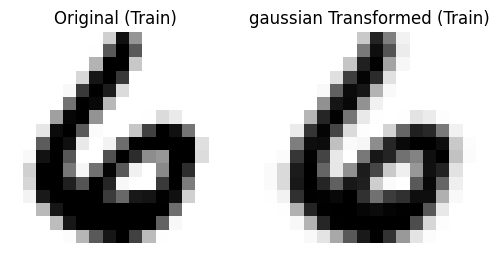

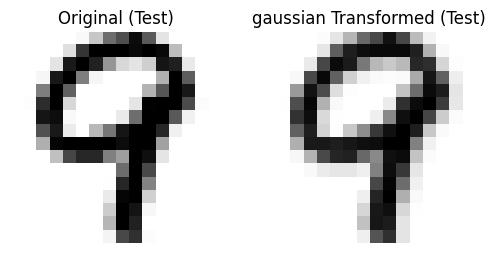

Applying laplacian kernel to the dataset...


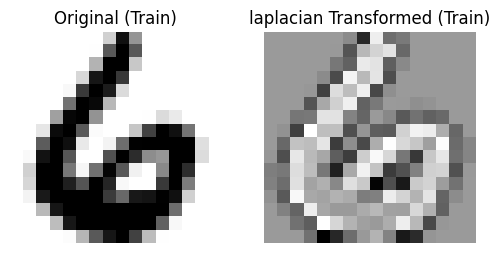

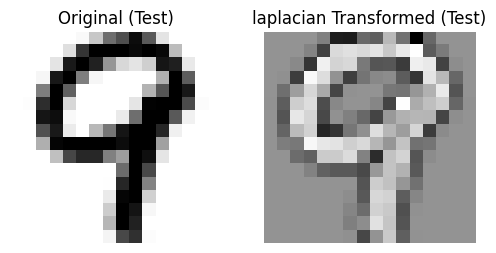

In [ ]:
# @title
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

def rbf_kernel(size=3, sigma=1.0):
    """Generates a Gaussian-like RBF kernel."""
    center = size // 2
    kernel = np.fromfunction(
        lambda x, y: np.exp(-((x - center)**2 + (y - center)**2) / (2 * sigma**2)),
        (size, size)
    )
    return kernel / np.sum(kernel)  # Normalize the kernel

def gaussian_kernel(size=3, sigma=1.0):
    """Generates a Gaussian blur kernel."""
    center = size // 2
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma**2)) * np.exp(-((x - center)**2 + (y - center)**2) / (2 * sigma**2)),
        (size, size)
    )
    return kernel / np.sum(kernel)  # Normalize the kernel

def laplacian_kernel():
    """Generates a Laplacian kernel for edge detection."""
    return np.array([[ 0,  1,  0],
                     [ 1, -4,  1],
                     [ 0,  1,  0]])

def apply_kernel(image, kernel):
    """
    Apply a specific kernel (filter) to an image.
    Args:
        image: Image (2D array).
        kernel: Convolution kernel (2D array).
    Returns:
        result: Image after applying the kernel (2D array).
    """
    return cv2.filter2D(image, -1, kernel)

def apply_kernel_to_dataset(data, kernel, image_size=(16, 16)):
    """
    Apply a single kernel to all images in the dataset.
    Args:
        data: Dataset containing images to transform (DataFrame).
        kernel: Convolution kernel (2D array) to apply.
        image_size: Tuple specifying the size to reshape images to (default is 16x16).
    Returns:
        transformed_images_df: DataFrame containing transformed images for each sample.
    """
    # Exclude the first row (row 0) which is labels
    labels = data.iloc[0]  # Capture the labels from the first row
    data = data.iloc[1:].reset_index(drop=True)  # Exclude the labels row

    transformed_images = []

    for index in range(data.shape[1]):  # Iterate over columns (images)
        # Reshape the image data to 16x16 after excluding the first row (labels)
        image = data.iloc[:, index].values.reshape(image_size)
        transformed_image = apply_kernel(image, kernel)
        transformed_images.append(transformed_image.flatten())  # Flatten the image for DataFrame

    # Convert the list of transformed images into a DataFrame
    transformed_images_df = pd.DataFrame(transformed_images).T

    # Add the labels back to the first row of the DataFrame
    transformed_images_df.loc[-1] = labels  # Insert labels as the first row
    transformed_images_df.index = transformed_images_df.index + 1  # Shift indices
    transformed_images_df = transformed_images_df.sort_index()  # Sort the DataFrame by index

    return transformed_images_df

# Example usage: Apply each kernel to the dataset in a loop
kernels = {
    "rbf": rbf_kernel(size=2, sigma=0.5),
    "gaussian": gaussian_kernel(size=2, sigma=0.5),
    "laplacian": laplacian_kernel()
}

transformed_dfs = {}

for kernel_name, kernel in kernels.items():
    print(f"Applying {kernel_name} kernel to the dataset...")

    # Apply kernel to the train_set and store the result in a DataFrame
    train_transformed_df = apply_kernel_to_dataset(train_set, kernel)
    transformed_dfs[f"train_{kernel_name}"] = train_transformed_df

    # Apply kernel to the test_set and store the result in a DataFrame
    test_transformed_df = apply_kernel_to_dataset(test_set, kernel)
    transformed_dfs[f"test_{kernel_name}"] = test_transformed_df

    # Plot the transformation for the first image for each kernel (train_set)
    first_image_train = train_set.iloc[1:, 0].values.reshape((16, 16))
    transformed_image_train = apply_kernel(first_image_train, kernel)

    # Plot the original and transformed images for train_set
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(first_image_train, cmap='binary')
    plt.title('Original (Train)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(transformed_image_train, cmap='binary')
    plt.title(f'{kernel_name} Transformed (Train)')
    plt.axis('off')
    plt.show()

    # Plot the transformation for the first image for each kernel (test_set)
    first_image_test = test_set.iloc[1:, 0].values.reshape((16, 16))
    transformed_image_test = apply_kernel(first_image_test, kernel)

    # Plot the original and transformed images for test_set
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(first_image_test, cmap='binary')
    plt.title('Original (Test)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(transformed_image_test, cmap='binary')
    plt.title(f'{kernel_name} Transformed (Test)')
    plt.axis('off')
    plt.show()



In [ ]:
# @title
transformed_dfs["train_rbf"]


,0,1,2,3,4,5,6,7,8,9,...,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706
0,6.000000,5.000000,4.000000,7.0,3.000000,6.000000,3.000000,1.0,0.000000,1.0,...,8.000000,0.000000,5.000000,1.0,9.000000,8.000000,9.0,7.0,9.0,8.000000
1,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,...,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
2,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,...,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
3,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,...,-1.000000,-1.000000,-0.972177,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
4,-1.000000,-0.708774,-1.000000,-1.0,-1.000000,-1.000000,-0.765745,-1.0,-1.000000,-1.0,...,-0.998425,-0.516561,-0.835279,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-0.929759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,-0.781385,0.296959,0.021072,-1.0,0.542831,-0.900734,-0.982790,-1.0,-0.540002,-1.0,...,-0.839555,-0.905276,-0.353402,-1.0,-0.999943,-0.742998,-1.0,-1.0,-1.0,-0.874761
253,-0.975749,0.058731,-0.894078,-1.0,0.010910,-0.998323,-0.999702,-1.0,-0.857680,-1.0,...,-0.990707,-0.990565,-0.578610,-1.0,-1.000000,-0.986201,-1.0,-1.0,-1.0,-0.993052
254,-0.999190,-0.411336,-1.000000,-1.0,-0.630508,-1.000000,-1.000000,-1.0,-0.987055,-1.0,...,-1.000000,-1.000000,-0.928828,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
255,-1.000000,-0.633931,-1.000000,-1.0,-0.948738,-1.000000,-1.000000,-1.0,-1.000000,-1.0,...,-1.000000,-1.000000,-0.996860,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000


In [ ]:
# @title
transformed_dfs["test_rbf"]

,0,1,2,3,4,5,6,7,8,9,...,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006
0,9.000000,6.0,3.000000,6.0,6.000000,0.000000,0.000000,0.000000,6.000000,9.0,...,7.000000,5.000000,2.000000,0.000000,4.0,3.000000,9.0,4.000000,0.000000,1.000000
1,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,...,-0.998949,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000
2,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,...,-0.992230,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000
3,-1.000000,-1.0,-0.953068,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,...,-0.952331,-1.000000,-1.000000,-0.998425,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000
4,-1.000000,-1.0,-0.468119,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,...,-0.875363,-0.798754,-0.880015,-0.983933,-1.0,-1.000000,-1.0,-0.966612,-0.962517,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,-0.997165,-1.0,-0.715712,-1.0,-0.610010,-0.363493,-0.924267,-0.045829,-0.935391,-1.0,...,-1.000000,-0.099984,-0.814231,-0.999233,-1.0,-0.761952,-1.0,-1.000000,-0.956771,-0.994622
253,-1.000000,-1.0,-0.863439,-1.0,-0.895672,-0.619838,-0.997812,-0.862629,-0.996064,-1.0,...,-1.000000,-0.826713,-0.074381,-1.000000,-1.0,-0.970137,-1.0,-1.000000,-0.997385,-1.000000
254,-1.000000,-1.0,-0.979368,-1.0,-0.988770,-0.947628,-1.000000,-0.994870,-1.000000,-1.0,...,-1.000000,-0.988920,0.349985,-1.000000,-1.0,-0.998806,-1.0,-1.000000,-1.000000,-1.000000
255,-1.000000,-1.0,-0.999233,-1.0,-0.999659,-0.998664,-1.000000,-1.000000,-1.000000,-1.0,...,-1.000000,-1.000000,-0.300352,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.000000,-1.000000


Running SVD for rbf:


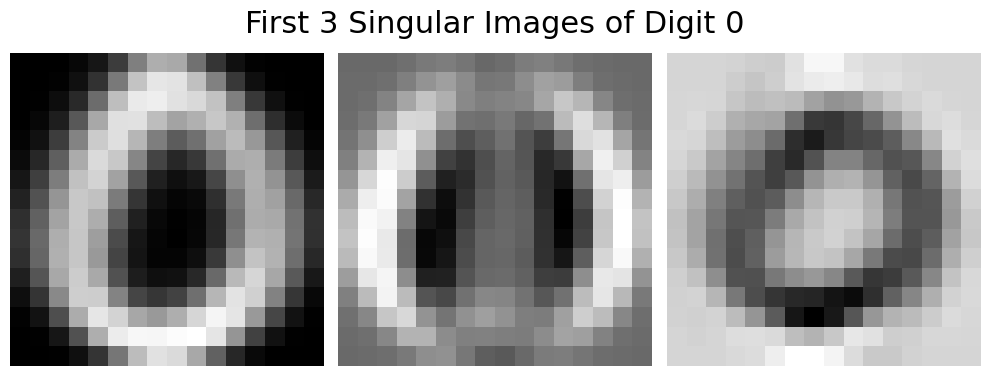

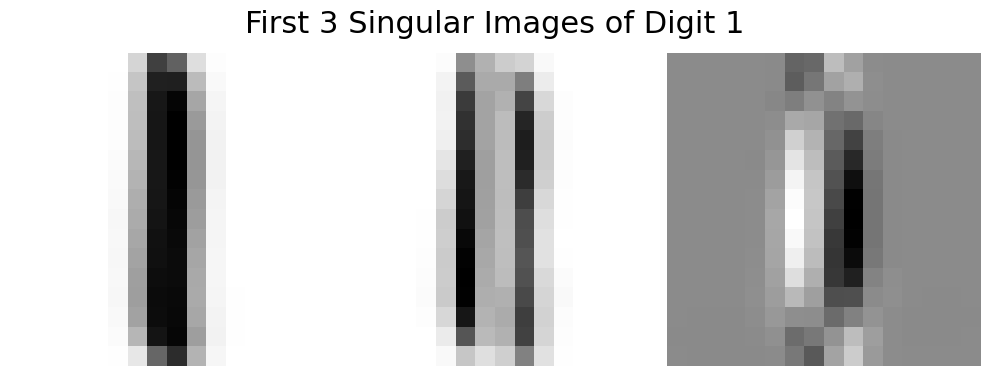

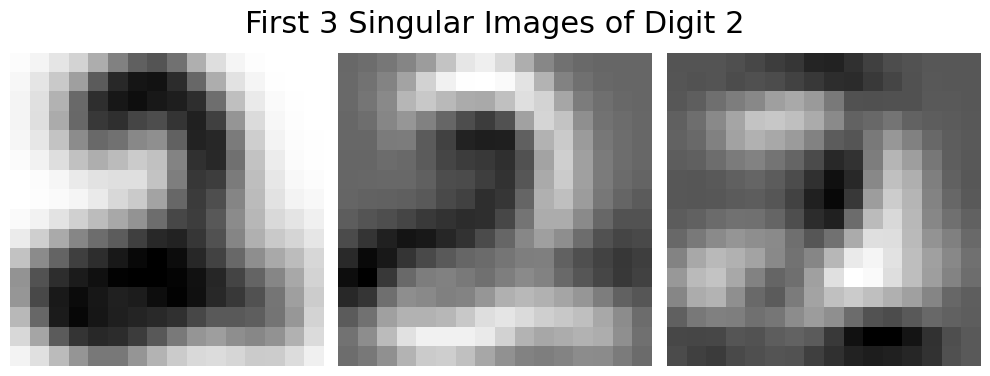

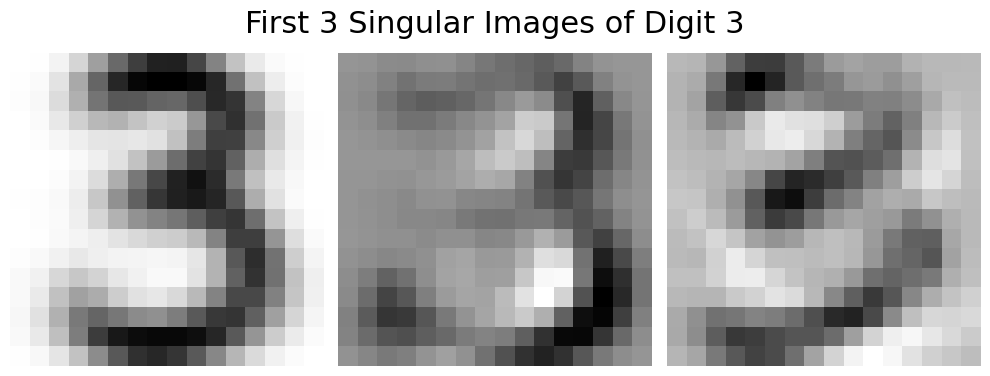

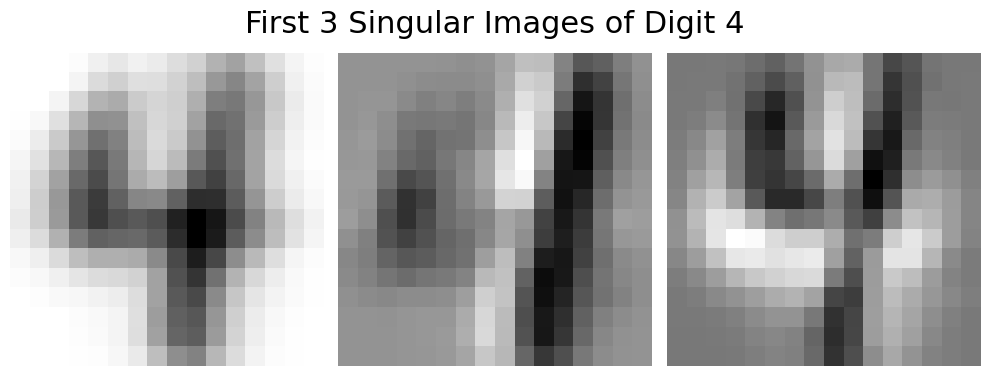

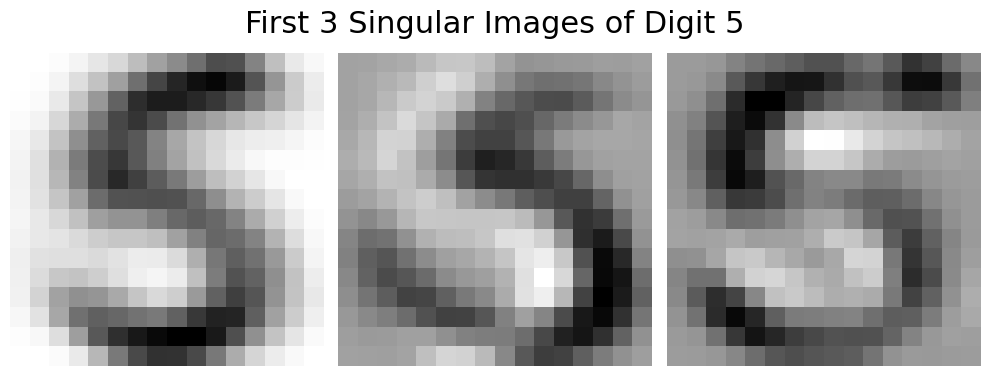

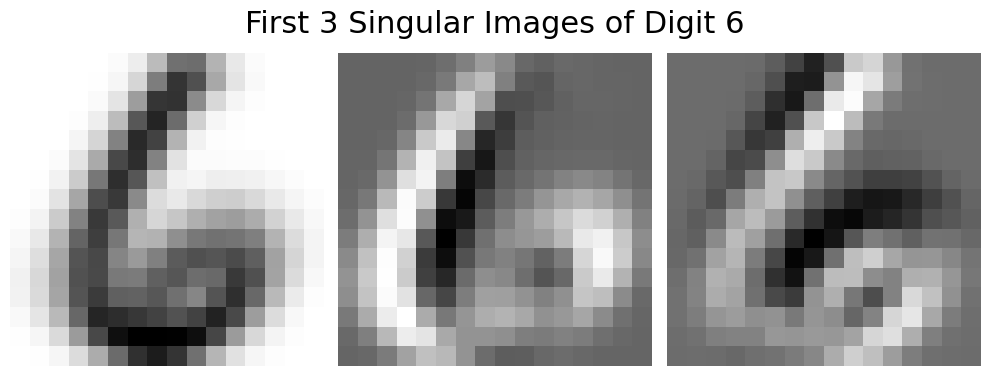

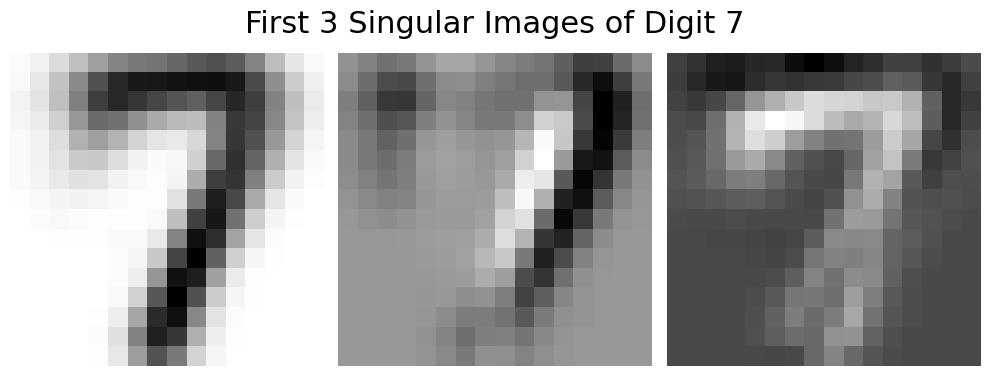

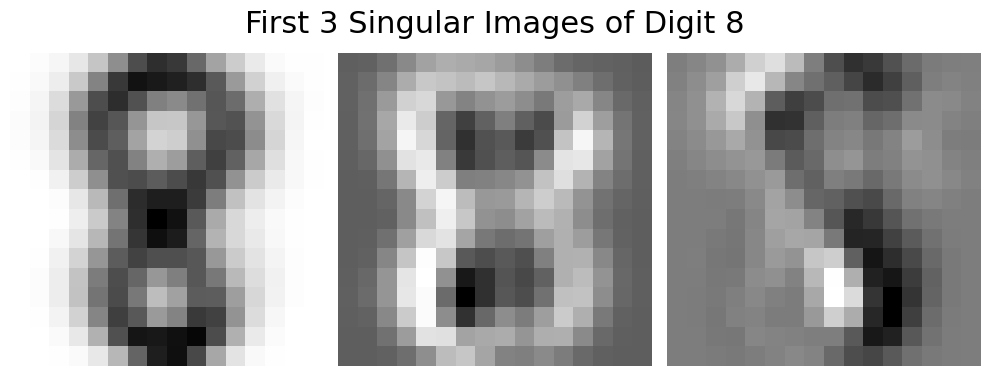

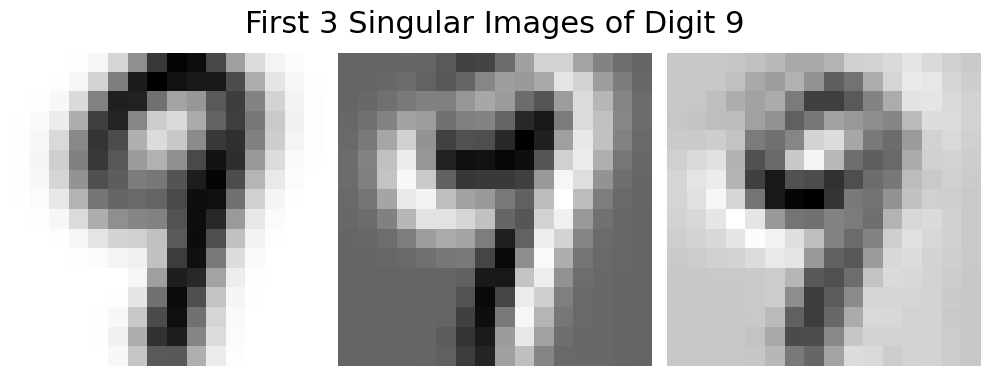



Running SVD for gaussian:


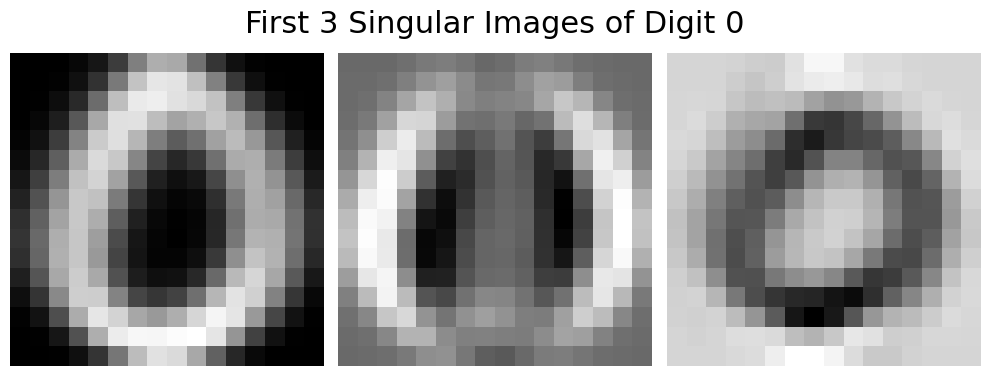

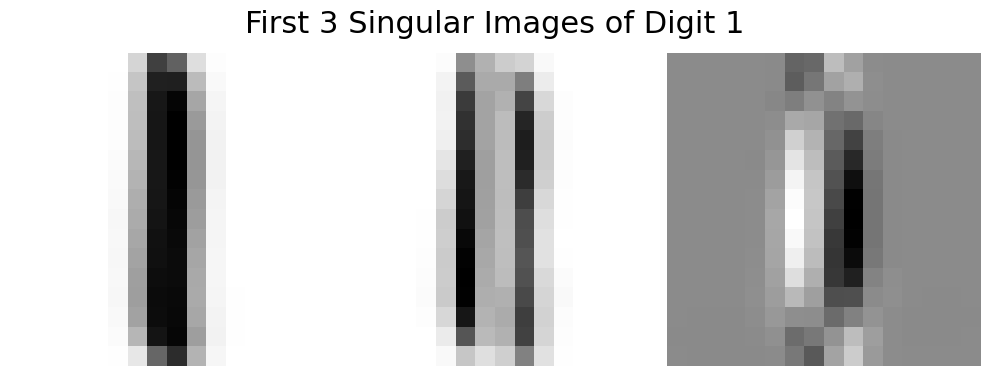

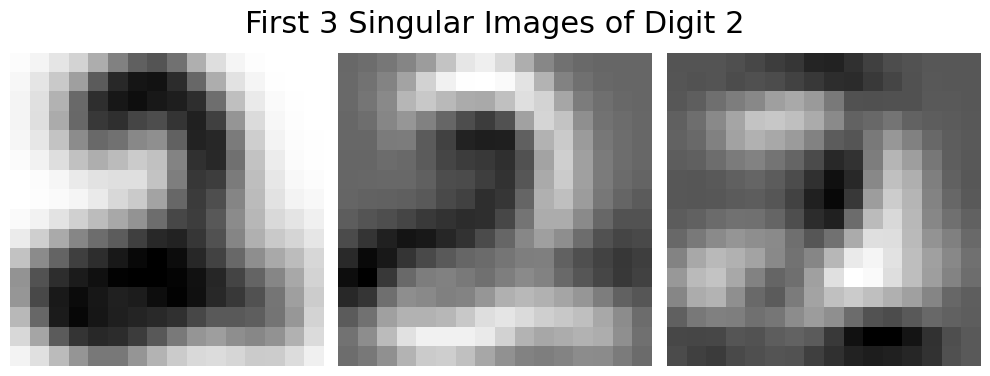

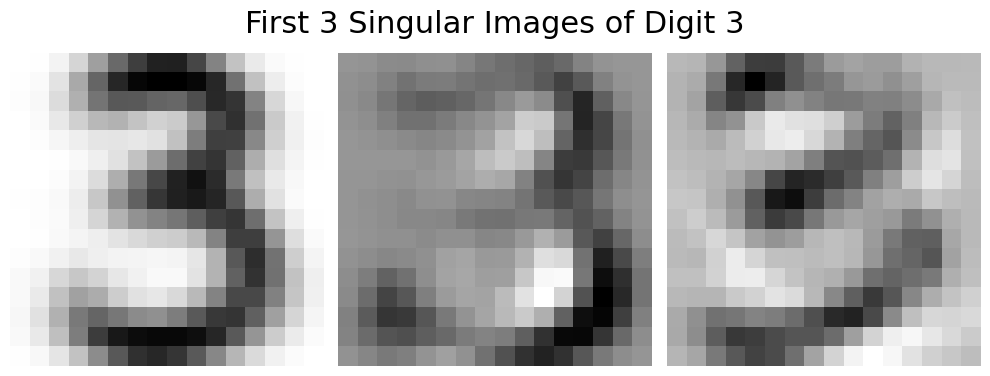

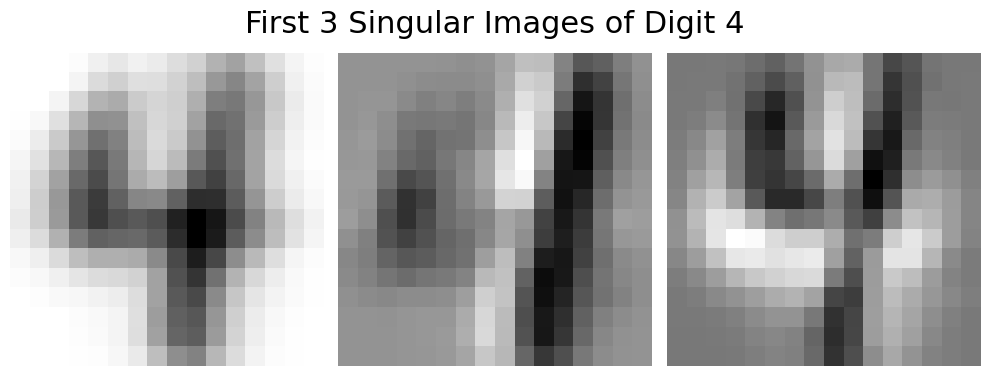

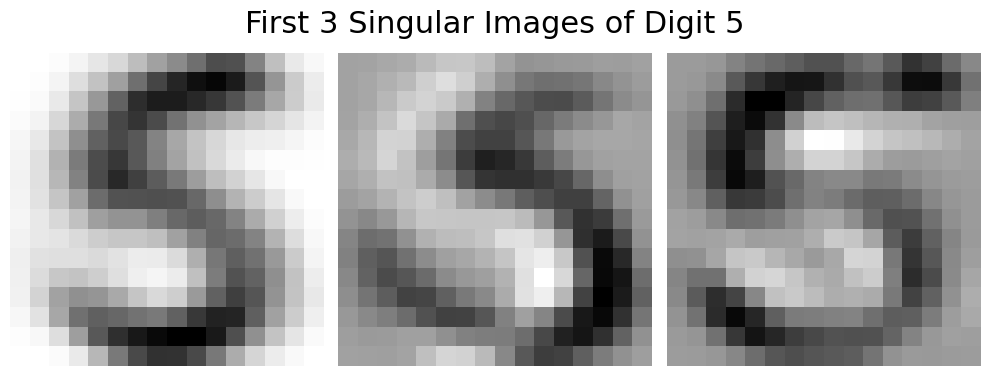

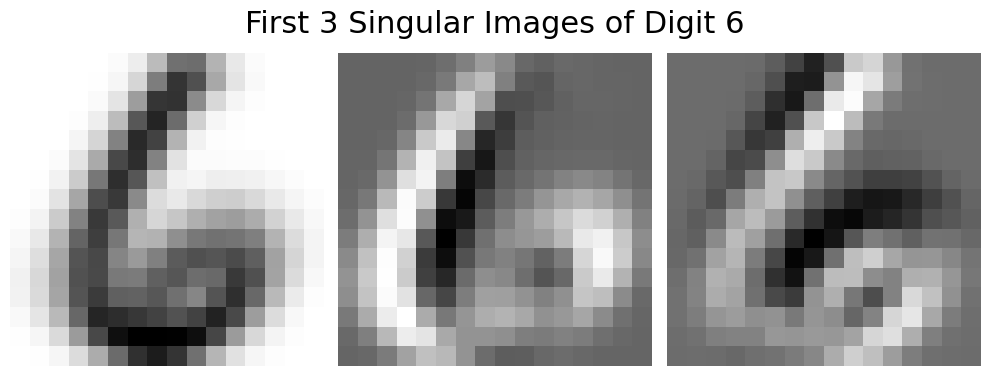

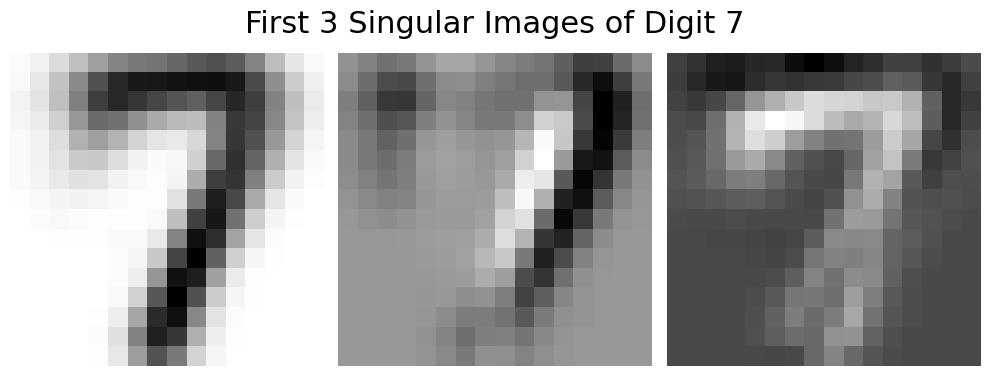

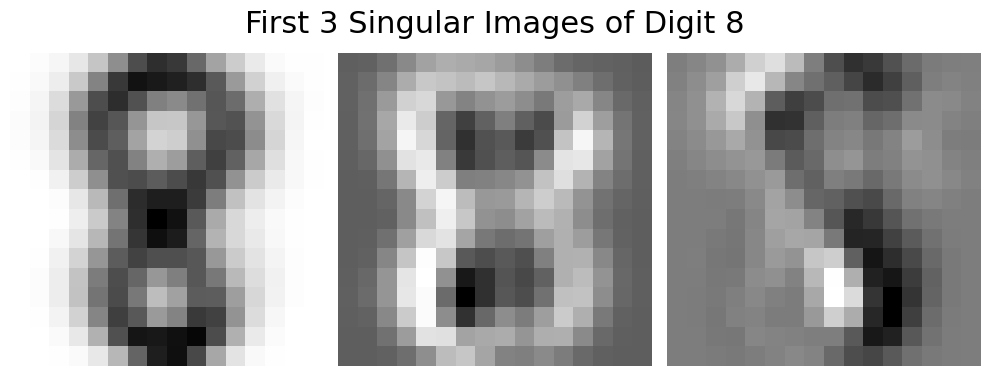

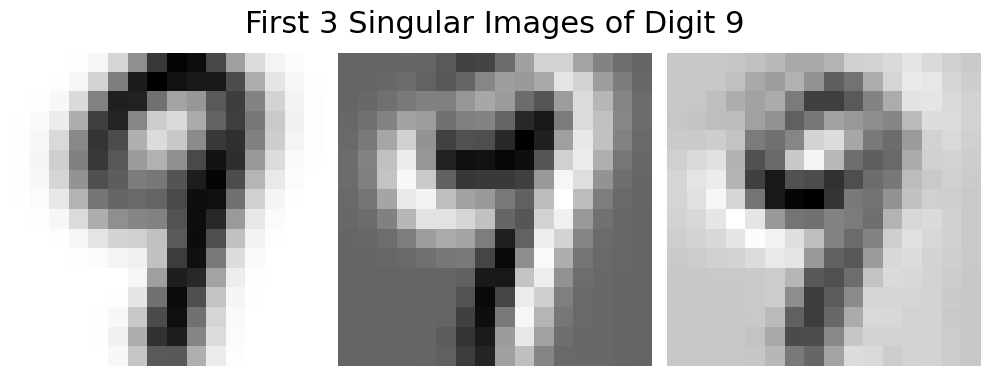



Running SVD for laplacian:


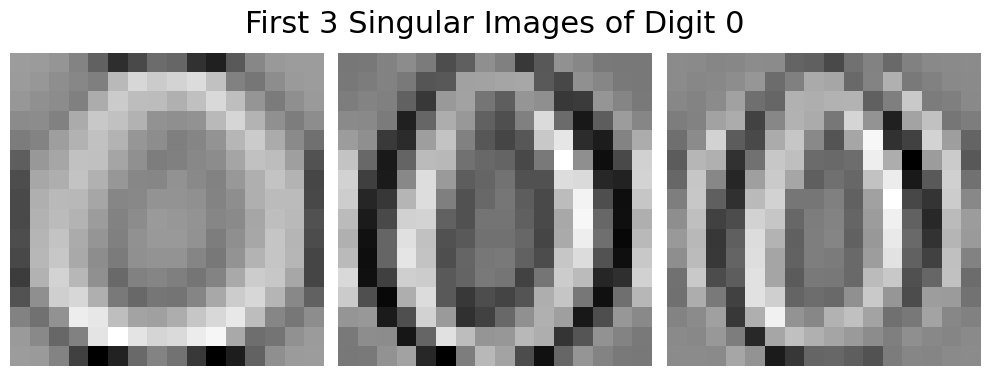

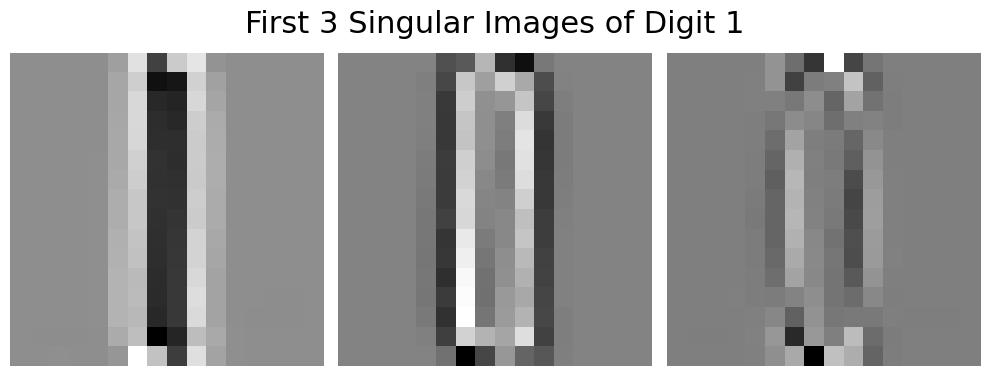

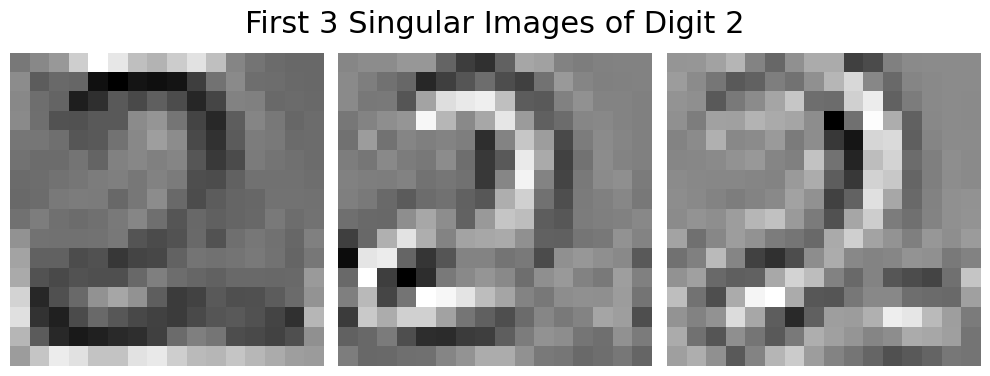

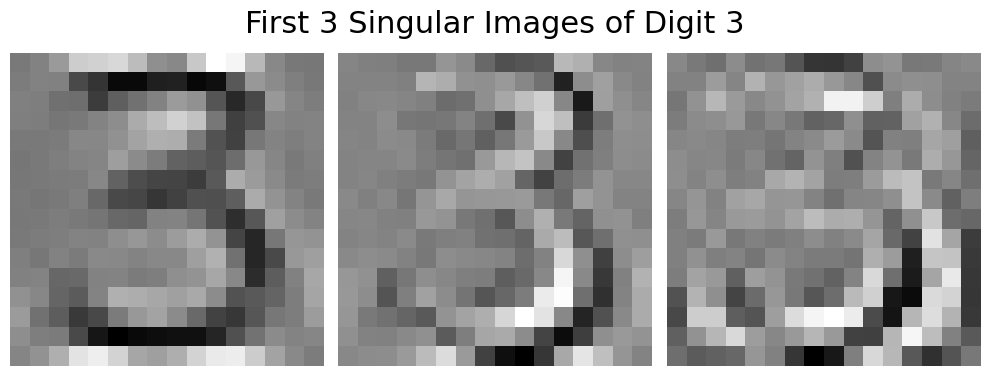

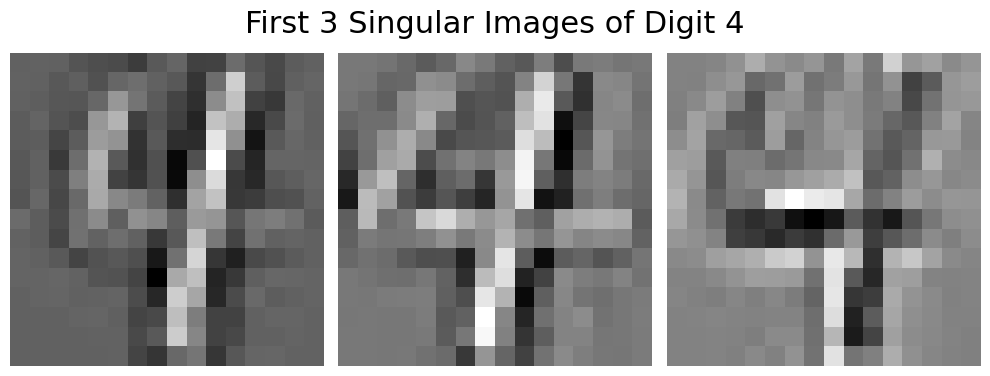

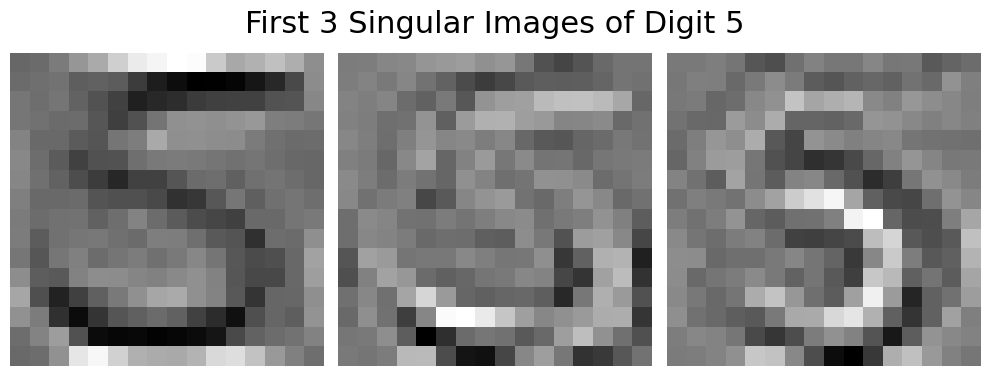

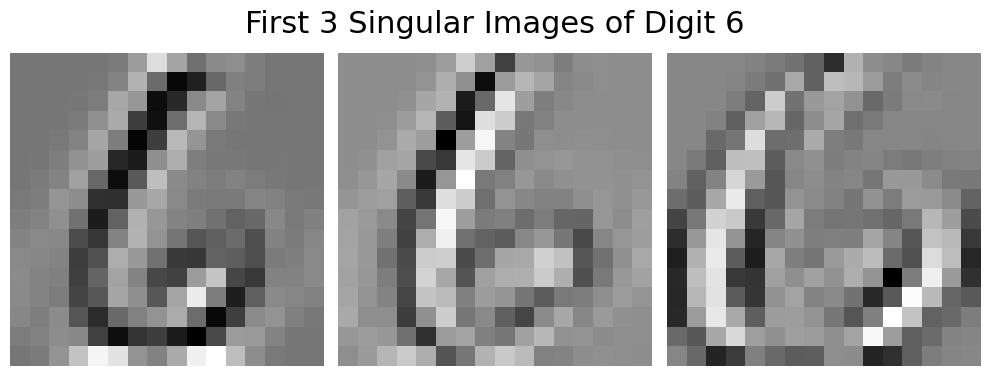

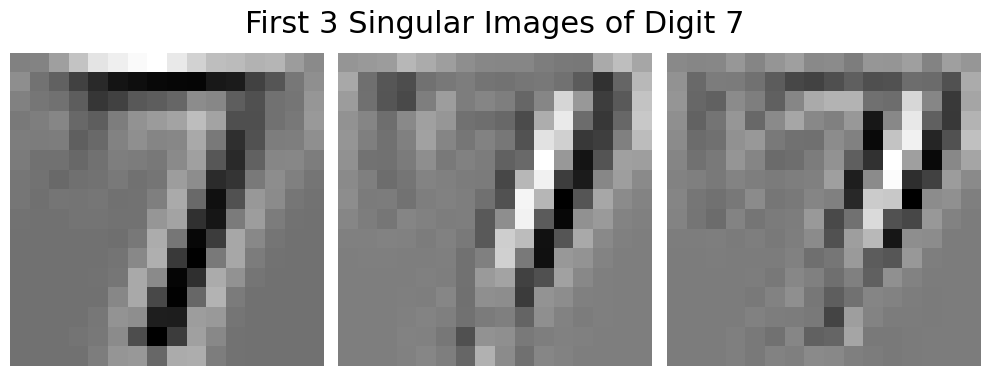

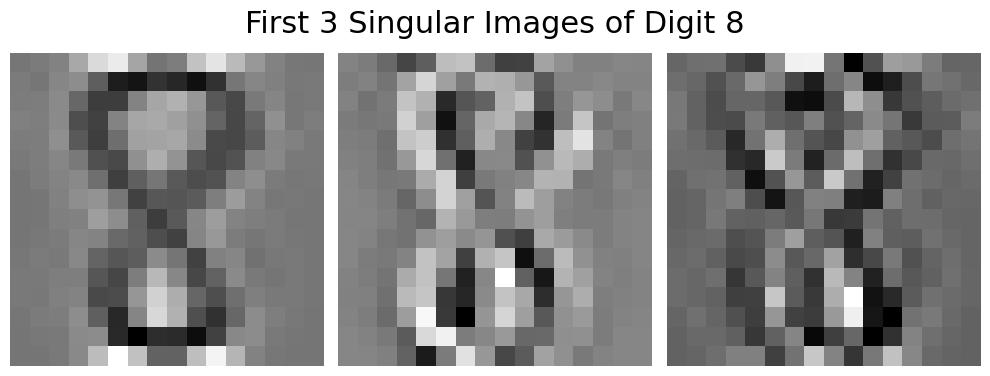

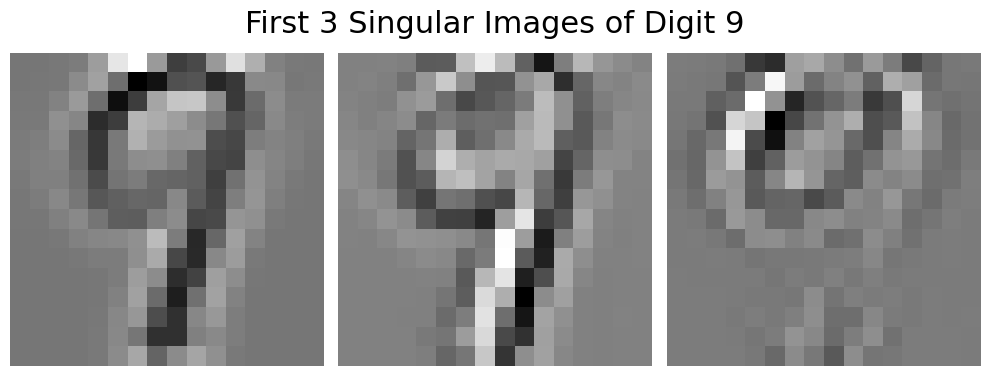

In [ ]:
# @title
transformed_train_dfs = {
    "rbf": transformed_dfs["train_rbf"],
    "gaussian": transformed_dfs["train_gaussian"],
    "laplacian": transformed_dfs["train_laplacian"],
}

# Loop over each transformation and perform SVD
for transformation_name, df in transformed_train_dfs.items():
    print(f"Running SVD for {transformation_name}:")
    u, s, vh = calculate_svd_for_all_digits(df)  # Compute SVD for the transformation
    for n in range(0,10):
      plot_singular_images(u, digit_index=n, num_images=3)
    print("\n")  # Separate output for clarity


Running SVD for rbf:
Making predictions on Training Set using  5 singular vectors. Accuracy: 82.61%
Making predictions on Training Set using  6 singular vectors. Accuracy: 83.26%
Making predictions on Training Set using  7 singular vectors. Accuracy: 83.71%
Making predictions on Training Set using  8 singular vectors. Accuracy: 84.06%
Making predictions on Training Set using  9 singular vectors. Accuracy: 84.90%
Making predictions on Training Set using 10 singular vectors. Accuracy: 85.45%
Making predictions on Training Set using 11 singular vectors. Accuracy: 85.55%
Making predictions on Training Set using 12 singular vectors. Accuracy: 85.80%
Making predictions on Training Set using 13 singular vectors. Accuracy: 85.85%
Making predictions on Training Set using 14 singular vectors. Accuracy: 86.50%
Making predictions on Training Set using 15 singular vectors. Accuracy: 86.30%
Making predictions on Training Set using 16 singular vectors. Accuracy: 86.35%
Making predictions on Training 

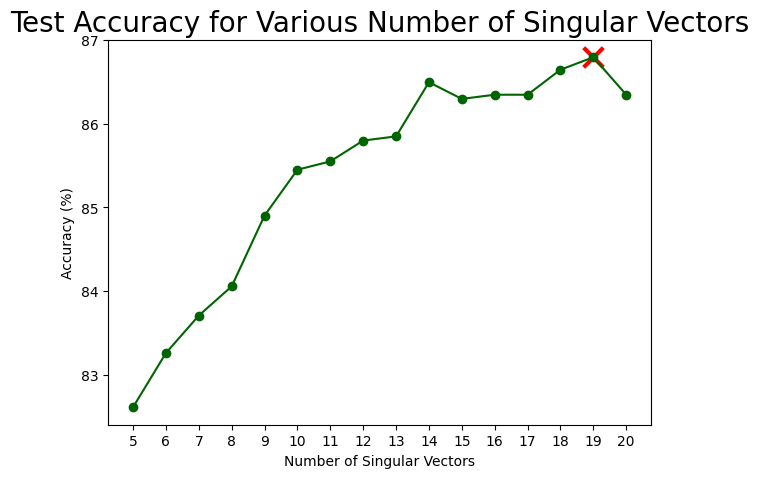

Making predictions on Test Set using 19 singular vectors.
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       359
         1.0       0.94      0.98      0.96       264
         2.0       0.90      0.83      0.86       198
         3.0       0.81      0.83      0.82       166
         4.0       0.69      0.90      0.78       200
         5.0       0.83      0.82      0.83       160
         6.0       0.93      0.86      0.90       170
         7.0       0.87      0.86      0.87       147
         8.0       0.95      0.73      0.82       166
         9.0       0.95      0.69      0.80       177

    accuracy                           0.87      2007
   macro avg       0.87      0.85      0.86      2007
weighted avg       0.88      0.87      0.87      2007

[[354   0   0   0   2   0   3   0   0   0]
 [  0 258   0   1   5   0   0   0   0   0]
 [ 14   1 164   5   4   2   3   2   3   0]
 [  7   0   3 137   2  14   0   0   2   1]
 [  2   4  

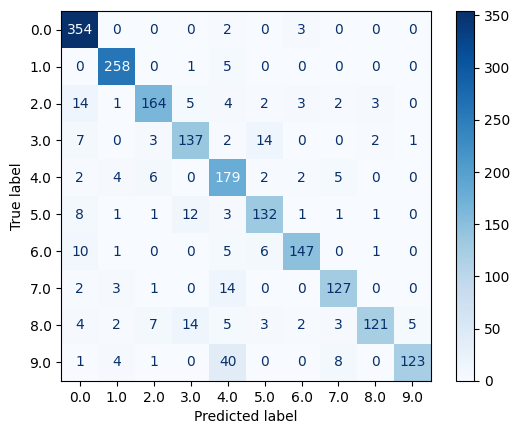

Running SVD for gaussian:
Making predictions on Training Set using  5 singular vectors. Accuracy: 82.61%
Making predictions on Training Set using  6 singular vectors. Accuracy: 83.26%
Making predictions on Training Set using  7 singular vectors. Accuracy: 83.71%
Making predictions on Training Set using  8 singular vectors. Accuracy: 84.06%
Making predictions on Training Set using  9 singular vectors. Accuracy: 84.90%
Making predictions on Training Set using 10 singular vectors. Accuracy: 85.45%
Making predictions on Training Set using 11 singular vectors. Accuracy: 85.55%
Making predictions on Training Set using 12 singular vectors. Accuracy: 85.80%
Making predictions on Training Set using 13 singular vectors. Accuracy: 85.85%
Making predictions on Training Set using 14 singular vectors. Accuracy: 86.50%
Making predictions on Training Set using 15 singular vectors. Accuracy: 86.30%
Making predictions on Training Set using 16 singular vectors. Accuracy: 86.35%
Making predictions on Trai

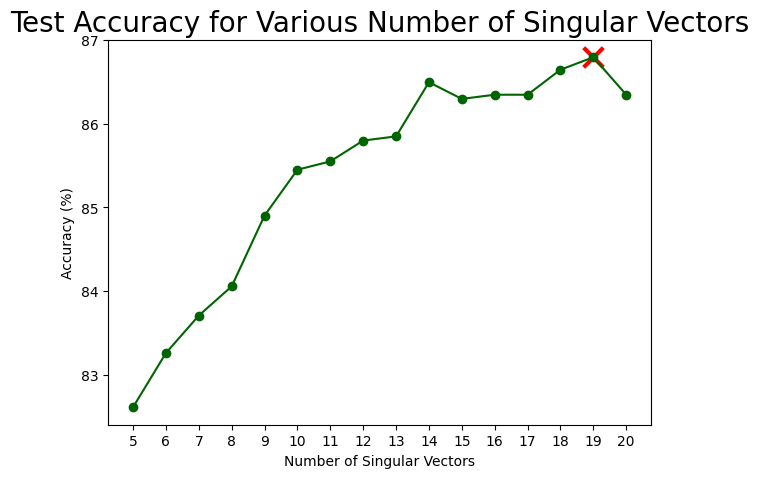

Making predictions on Test Set using 19 singular vectors.
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       359
         1.0       0.94      0.98      0.96       264
         2.0       0.90      0.83      0.86       198
         3.0       0.81      0.83      0.82       166
         4.0       0.69      0.90      0.78       200
         5.0       0.83      0.82      0.83       160
         6.0       0.93      0.86      0.90       170
         7.0       0.87      0.86      0.87       147
         8.0       0.95      0.73      0.82       166
         9.0       0.95      0.69      0.80       177

    accuracy                           0.87      2007
   macro avg       0.87      0.85      0.86      2007
weighted avg       0.88      0.87      0.87      2007

[[354   0   0   0   2   0   3   0   0   0]
 [  0 258   0   1   5   0   0   0   0   0]
 [ 14   1 164   5   4   2   3   2   3   0]
 [  7   0   3 137   2  14   0   0   2   1]
 [  2   4  

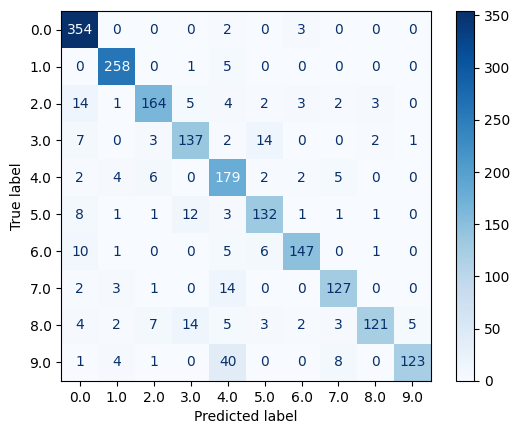

Running SVD for laplacian:
Making predictions on Training Set using  5 singular vectors. Accuracy: 78.18%
Making predictions on Training Set using  6 singular vectors. Accuracy: 79.77%
Making predictions on Training Set using  7 singular vectors. Accuracy: 80.27%
Making predictions on Training Set using  8 singular vectors. Accuracy: 80.12%
Making predictions on Training Set using  9 singular vectors. Accuracy: 81.51%
Making predictions on Training Set using 10 singular vectors. Accuracy: 82.26%
Making predictions on Training Set using 11 singular vectors. Accuracy: 82.76%
Making predictions on Training Set using 12 singular vectors. Accuracy: 83.71%
Making predictions on Training Set using 13 singular vectors. Accuracy: 83.51%
Making predictions on Training Set using 14 singular vectors. Accuracy: 83.76%
Making predictions on Training Set using 15 singular vectors. Accuracy: 83.66%
Making predictions on Training Set using 16 singular vectors. Accuracy: 83.71%
Making predictions on Tra

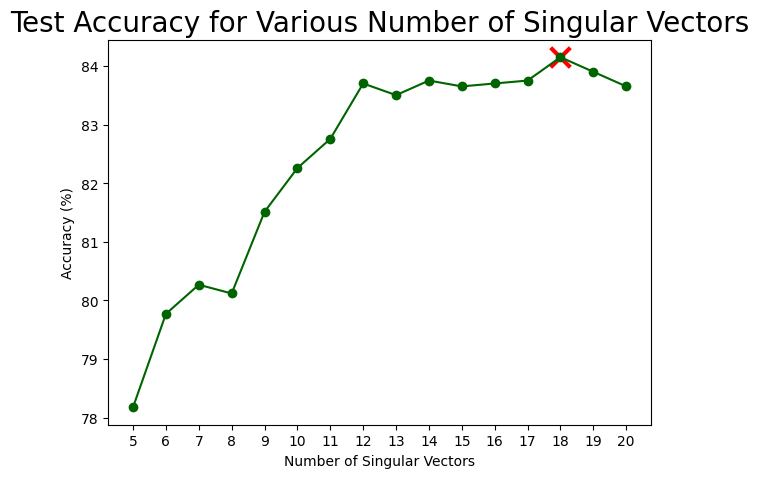

Making predictions on Test Set using 18 singular vectors.
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91       359
         1.0       0.90      0.98      0.94       264
         2.0       0.91      0.77      0.84       198
         3.0       0.71      0.81      0.76       166
         4.0       0.91      0.65      0.76       200
         5.0       0.86      0.63      0.73       160
         6.0       0.82      0.89      0.86       170
         7.0       0.74      0.93      0.82       147
         8.0       0.85      0.77      0.81       166
         9.0       0.81      0.87      0.84       177

    accuracy                           0.84      2007
   macro avg       0.84      0.83      0.83      2007
weighted avg       0.85      0.84      0.84      2007

[[343   1   3   1   1   1   8   0   0   1]
 [  2 258   0   0   1   0   1   0   2   0]
 [ 17   1 153   5   5   0   5   5   3   4]
 [ 10   0   3 135   0   9   2   1   6   0]
 [  2  12  

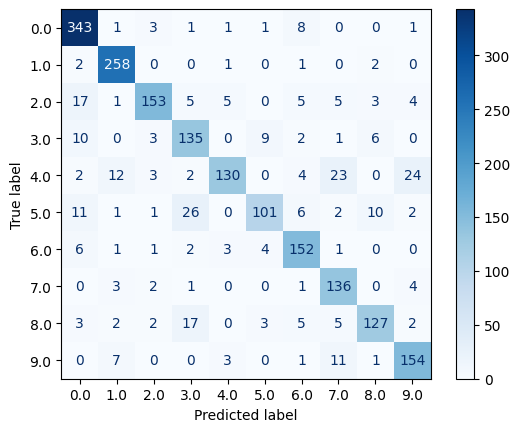

In [ ]:
# @title
transformed_test_dfs = {
    "rbf": transformed_dfs["test_rbf"],
    "gaussian": transformed_dfs["test_gaussian"],
    "laplacian": transformed_dfs["test_laplacian"],
}


# Loop over each transformation and perform SVD
for transformation_name, df in transformed_test_dfs.items():
    print(f"Running SVD for {transformation_name}:")
    # Run the tuning function to get the best base and accuracies
    best_base, accuracies = tune_singular_vectors(df)

    # Check if accuracies have been populated
    print("Accuracy list:", accuracies)

    # Plotting section
    if accuracies:  # Only plot if accuracies are available
        fig = plt.figure(figsize=(7, 5))

        best_accuracy = np.array(accuracies).max()  # Maximum accuracy in percentage
        plt.scatter(best_base, best_accuracy, marker='x', c='r', s=200, linewidths=3)

        # Plot the accuracy curve for all bases with a custom color
        plt.plot(range(5, 21), np.array(accuracies), marker='o', color='darkgreen', label="Accuracy for each base")

        # Add labels and title
        plt.ylabel("Accuracy (%)")
        plt.xlabel("Number of Singular Vectors")
        plt.xticks(range(5, 21))
        plt.title('Test Accuracy for Various Number of Singular Vectors', fontsize=20, y=1)

        # Show the plot
        plt.show()
    else:
        print("Error: Accuracy list is empty. Please check the calculation process.")
    predictions, labels, misclassified_indices = make_predictions(accuracies, df, calc_resid)


### Results of SVD on Different Kernels

#### 1. **RBF Kernel:**
   - **Accuracy**: 87%
   - The precision, recall, and F1 scores are generally high across all classes, with class 0 showing the highest performance, especially in terms of recall (99%).
   - The F1 score is strong for most classes, peaking at 0.96 for class 1 and dipping to 0.80 for class 9.
   - The macro average of 0.86 suggests a balanced performance across all classes, with no particular class significantly outperforming the others.
   - The weighted average of 0.87 indicates that the model is doing well on the test set, accounting for class imbalances.

#### 2. **Gaussian Kernel:**
   - **Accuracy**: 87%
   - Similar to the RBF kernel, the performance metrics remain consistent across the Gaussian kernel. Precision and recall are well-balanced, with class 0 exhibiting near-perfect recall (99%) and class 4 having the lowest F1 score at 0.78.
   - The overall performance is comparable to the RBF kernel, with no significant variations in accuracy or the classification metrics.

#### 3. **Laplacian Kernel:**
   - **Accuracy**: 84%
   - The accuracy is slightly lower than the RBF and Gaussian kernels, at 84%, indicating a slight degradation in performance.
   - Class 0 and class 1 still perform well, with recall values of 96% and 98%, respectively, but there is a noticeable dip in performance for classes 4, 5, and 6.
   - The precision and recall for classes 5 and 6 are lower compared to the other kernels, which may indicate the model's difficulty in capturing these classes as effectively.
   - The macro average of 0.83 and weighted average of 0.84 suggest that the Laplacian kernel is less robust across the classes compared to the other two kernels.

### Conclusion:
- The **RBF** and **Gaussian** kernels deliver very similar and strong performance with an accuracy of 87%, while the **Laplacian** kernel shows slightly lower accuracy at 84%.
- The higher performance of RBF and Gaussian kernels might make them preferable choices over the Laplacian kernel in this specific setting.


Plotting misclassified samples for RBF kernel...


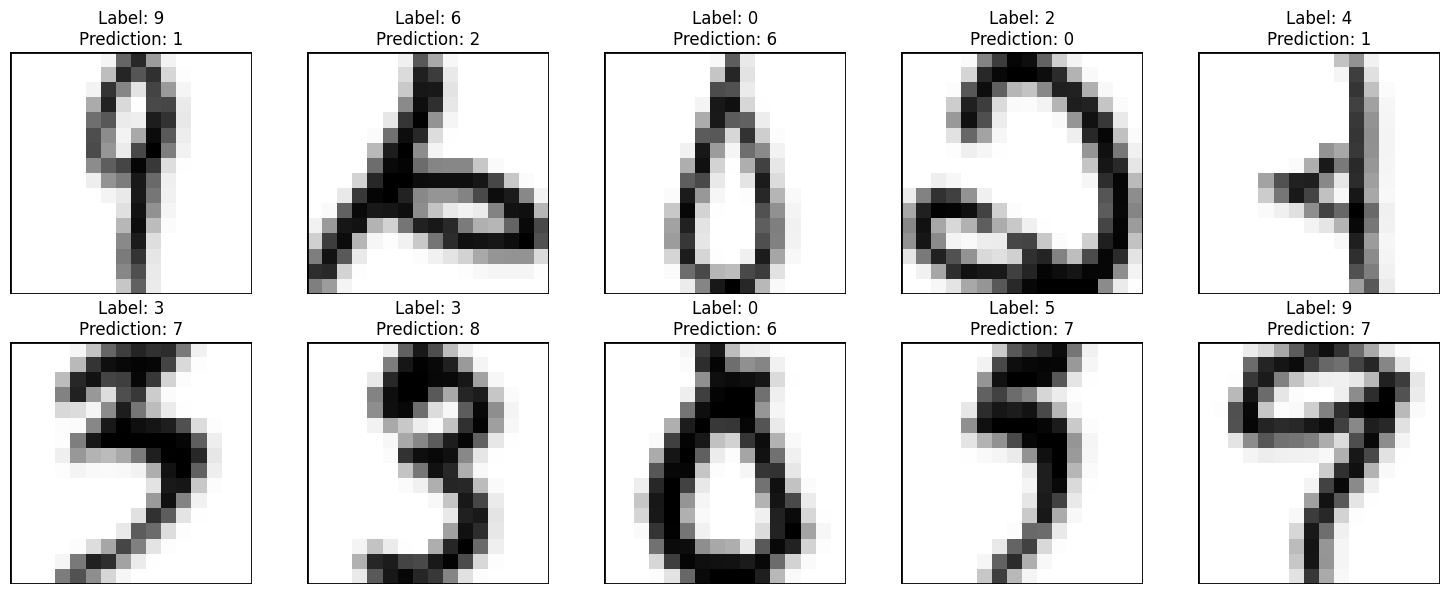

Plotting misclassified samples for Gaussian kernel...


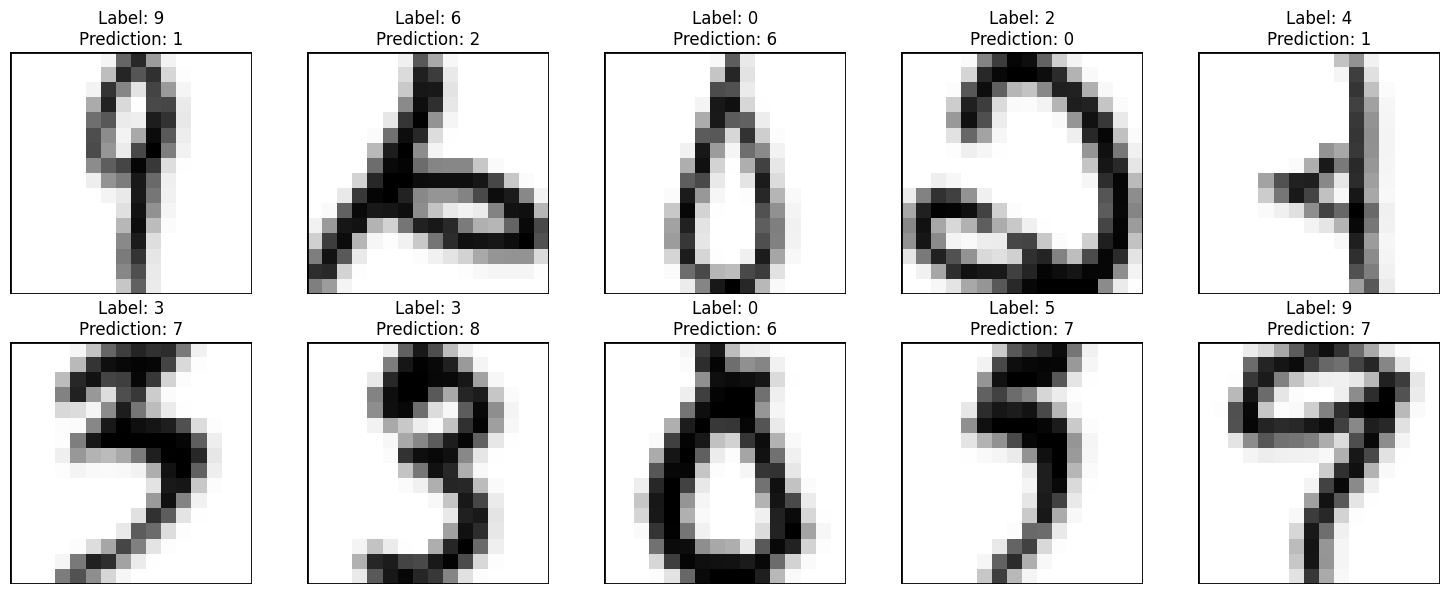

Plotting misclassified samples for Laplacian kernel...


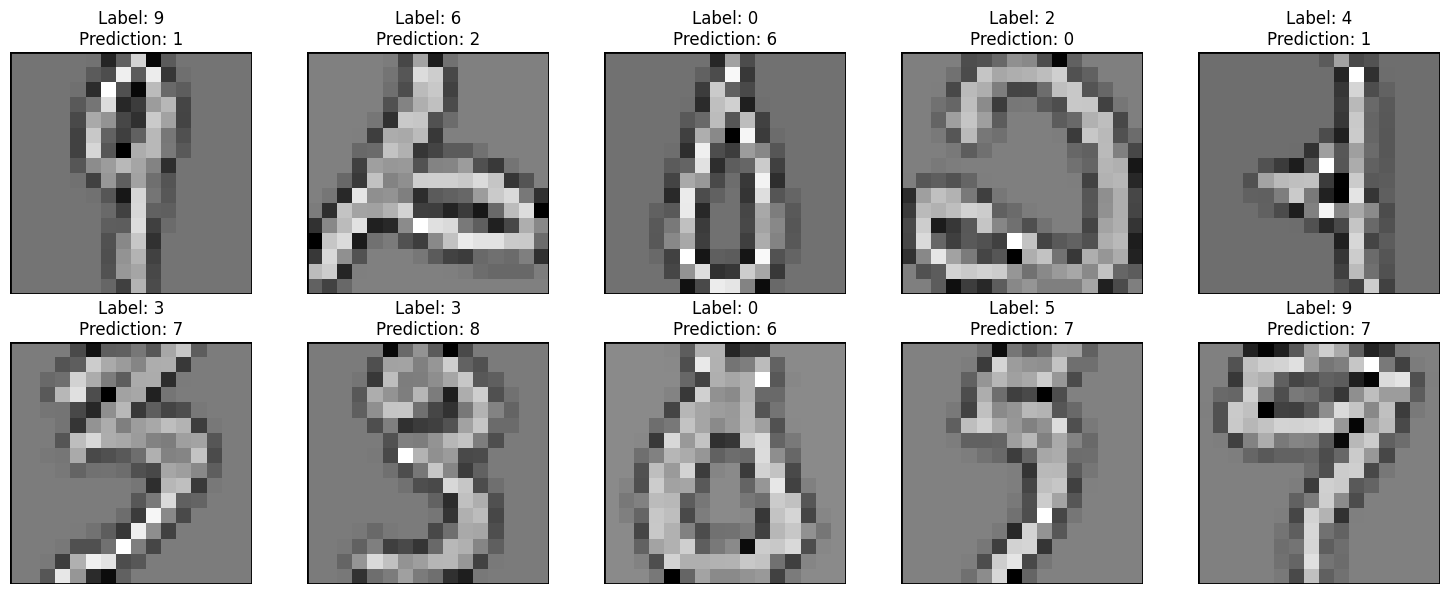

In [ ]:
# @title
# Plot misclassified samples for the RBF kernel with a message
print("Plotting misclassified samples for RBF kernel...")
plot_misclassified_samples(transformed_dfs["test_rbf"], labels, predictions, misclassified_indices, seed=200)

# Plot misclassified samples for the Gaussian kernel with a message
print("Plotting misclassified samples for Gaussian kernel...")
plot_misclassified_samples(transformed_dfs["test_gaussian"], labels, predictions, misclassified_indices, seed=200)

# Plot misclassified samples for the Laplacian kernel with a message
print("Plotting misclassified samples for Laplacian kernel...")
plot_misclassified_samples(transformed_dfs["test_laplacian"], labels, predictions, misclassified_indices, seed=200)


Plotting singular values for RBF kernel...


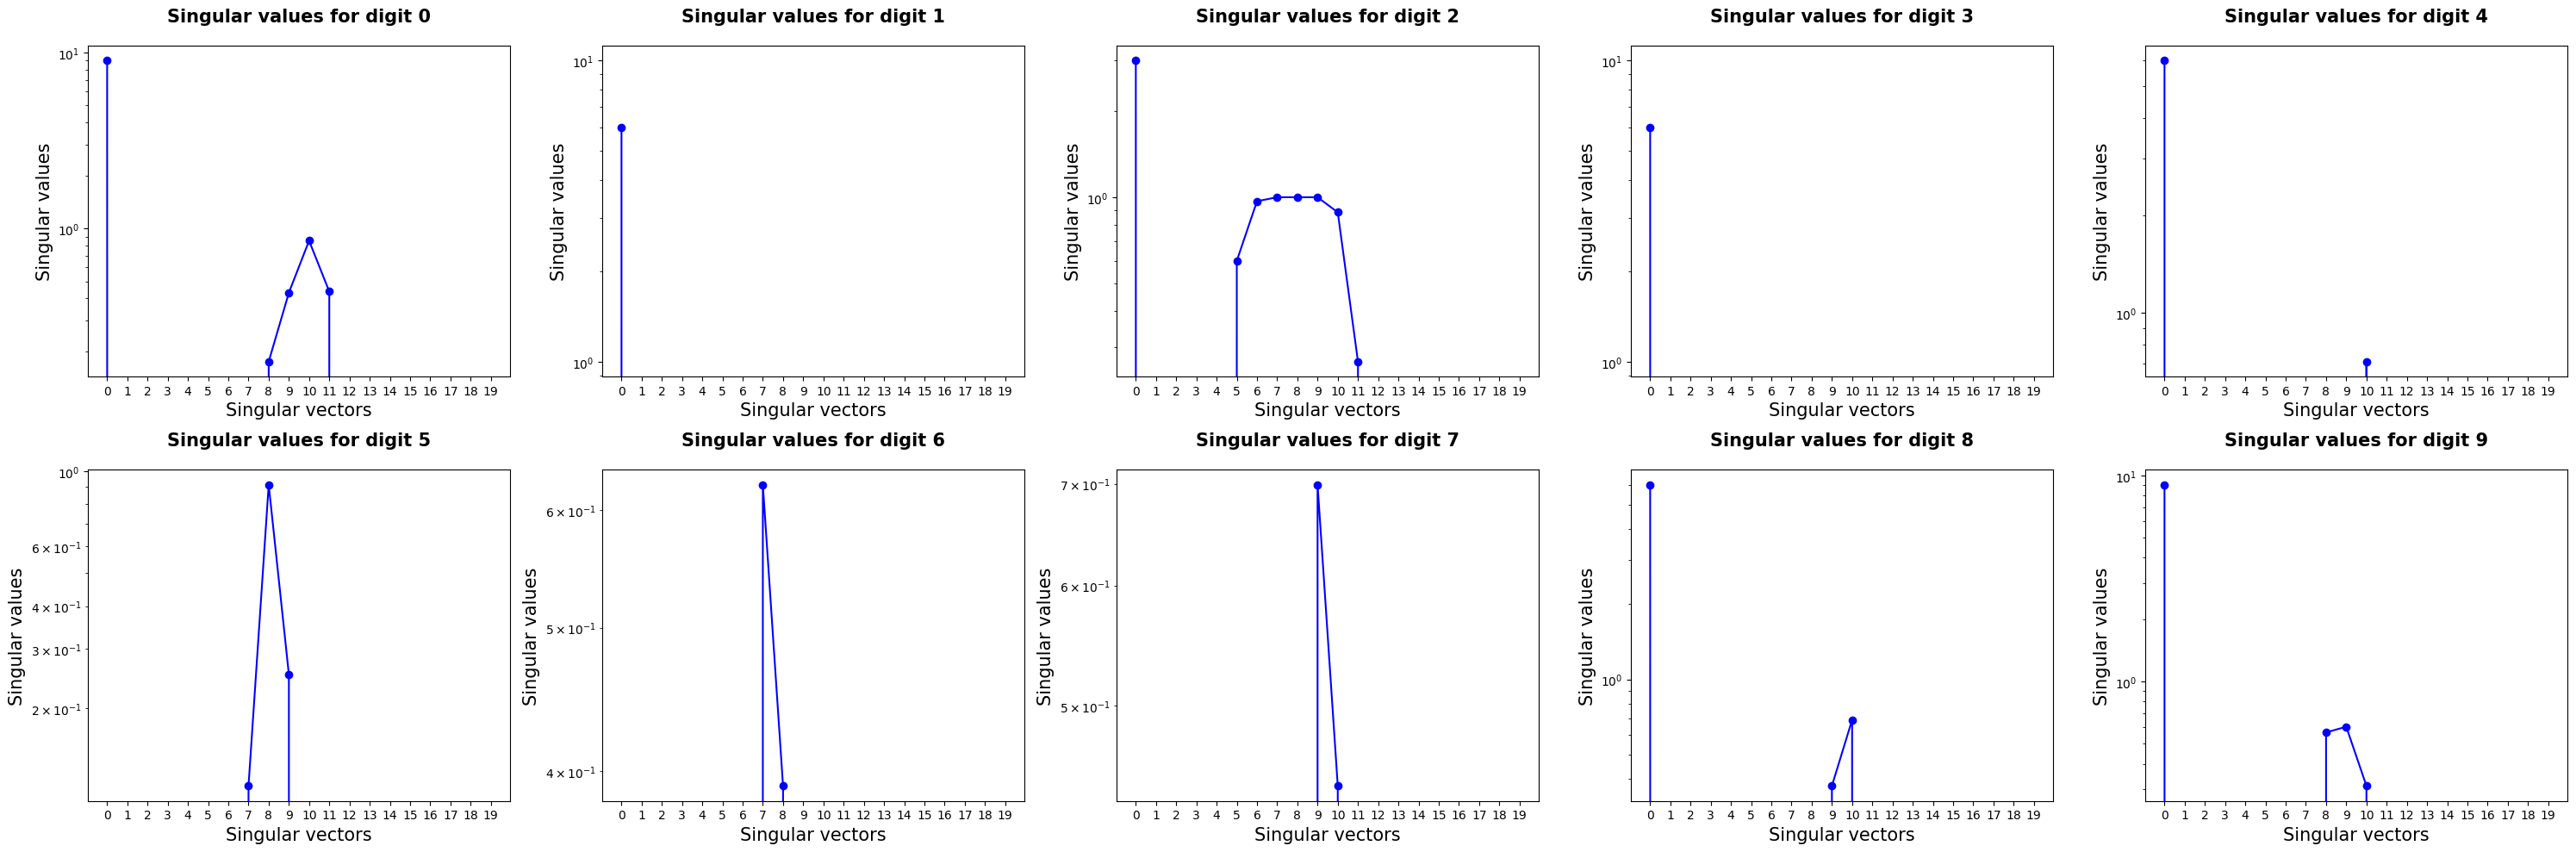

Plotting singular values for Gaussian kernel...


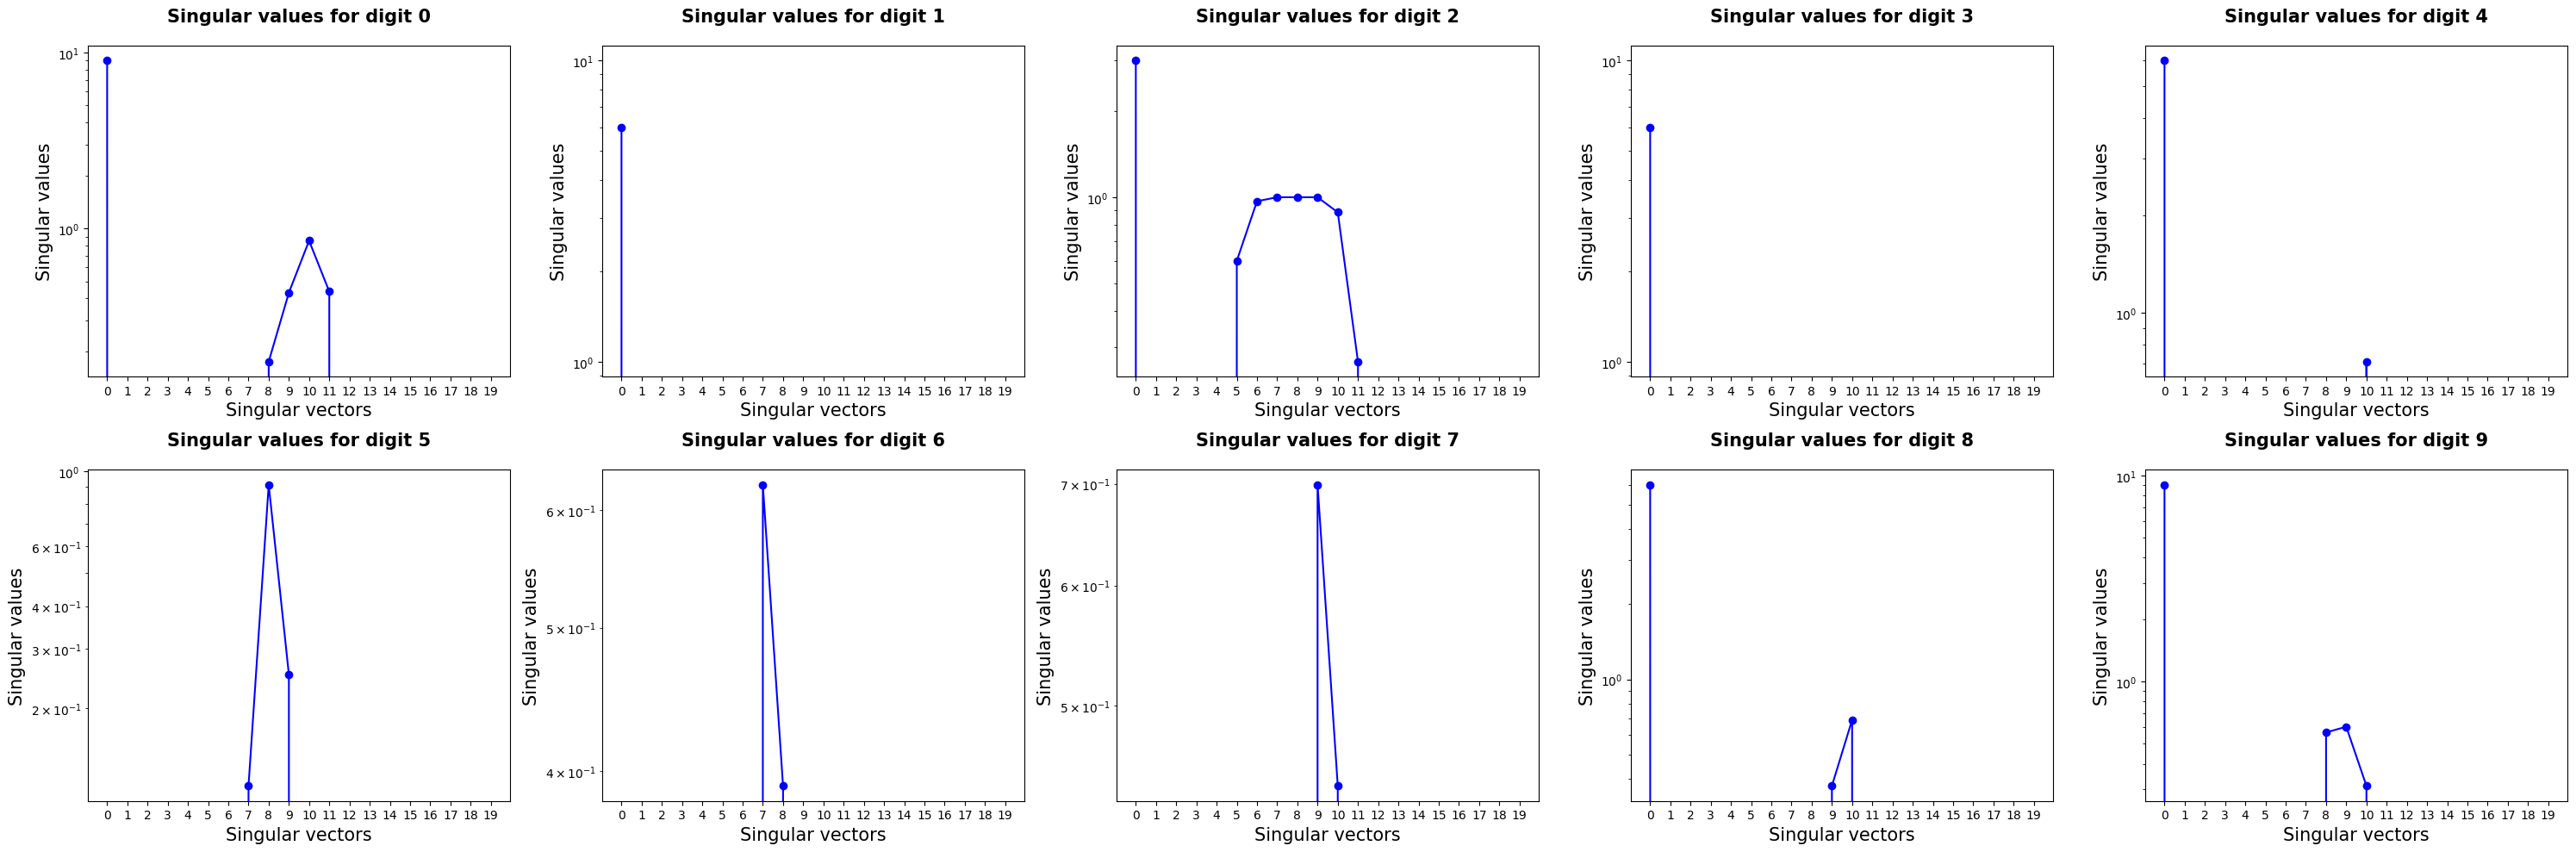

Plotting singular values for Laplacian kernel...


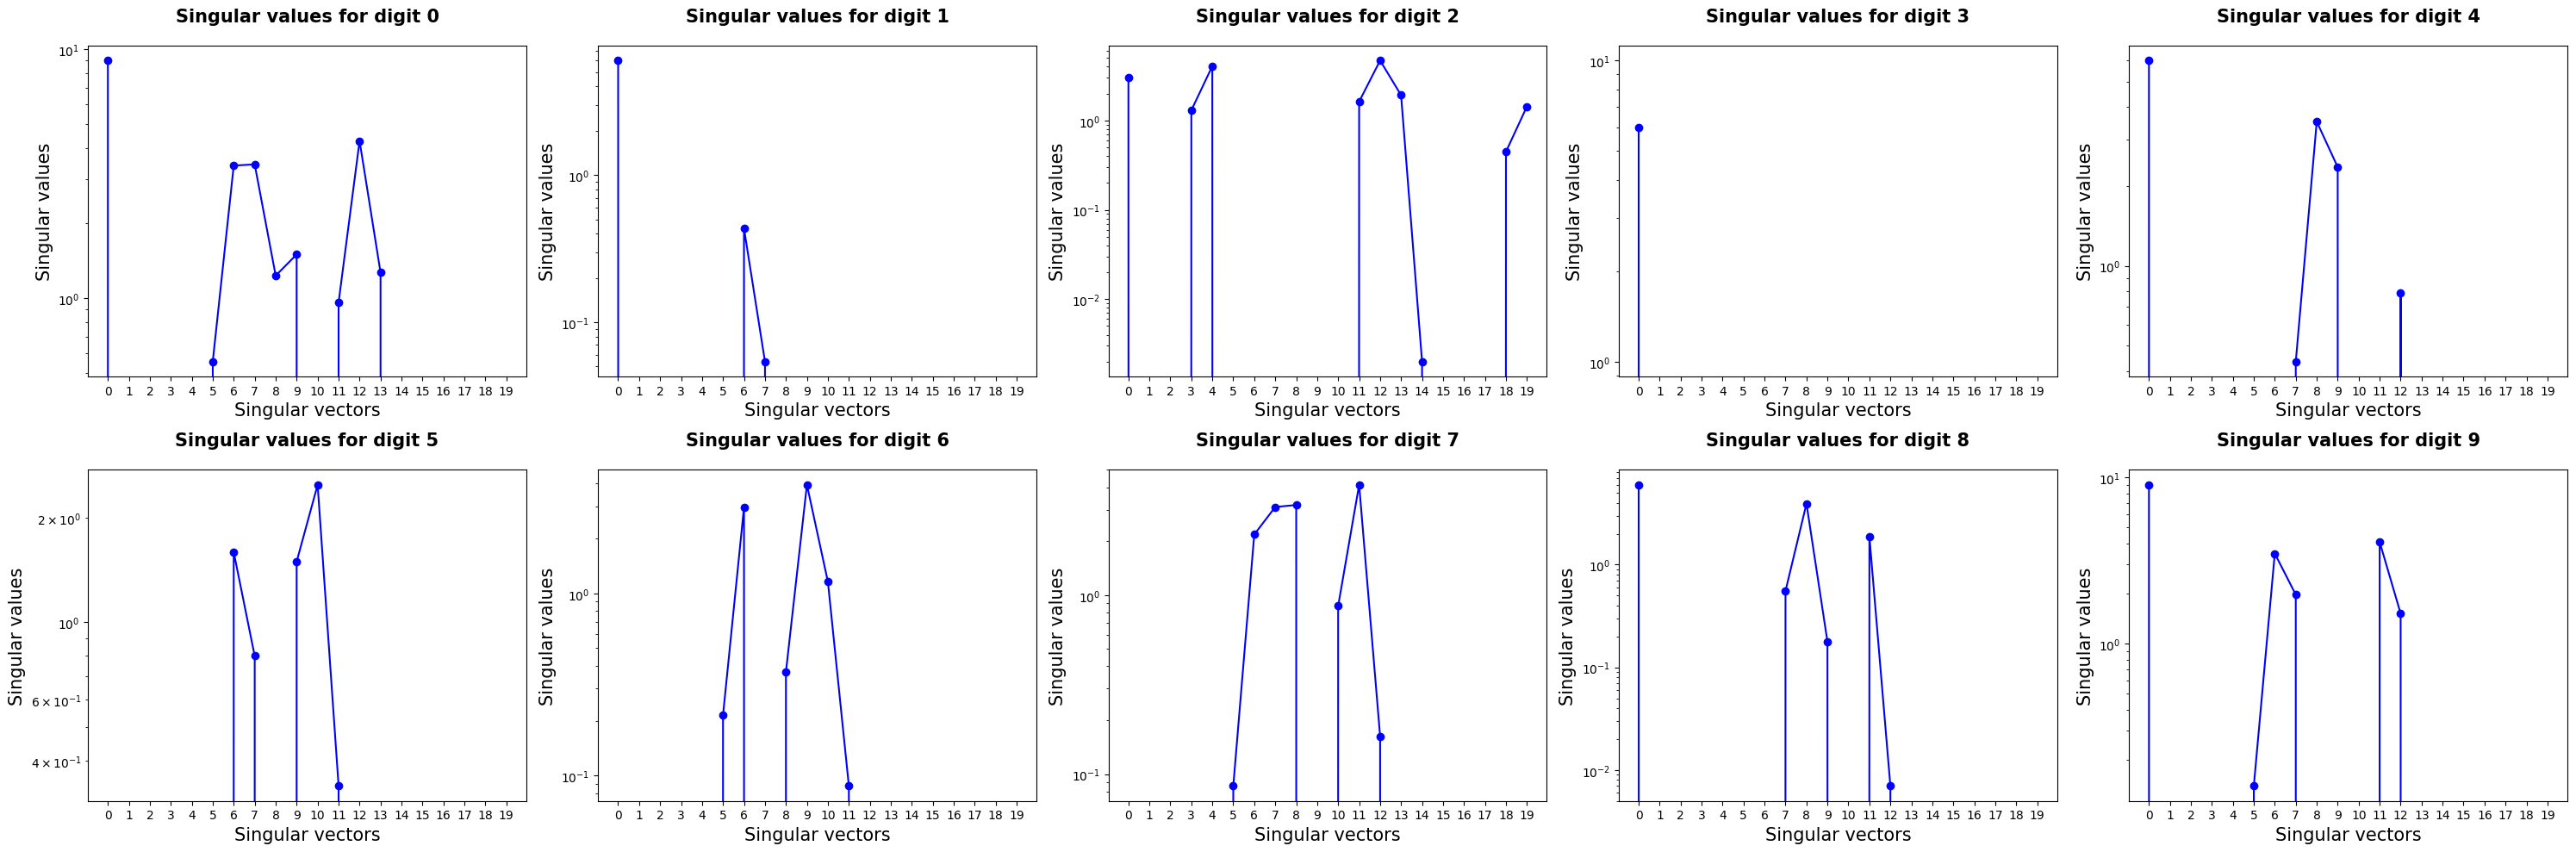

In [ ]:
# @title

# Plot singular values for the RBF kernel with a message
print("Plotting singular values for RBF kernel...")
plot_singular_values(transformed_dfs["test_rbf"])

# Plot singular values for the Gaussian kernel with a message
print("Plotting singular values for Gaussian kernel...")
plot_singular_values(transformed_dfs["test_gaussian"])

# Plot singular values for the Laplacian kernel with a message
print("Plotting singular values for Laplacian kernel...")
plot_singular_values(transformed_dfs["test_laplacian"])


### Two-Stage Algorithm for Handwritten Digit Classification Using SVD

In this section, we evaluate the performance of a **two-stage algorithm** for handwritten digit classification using **Singular Value Decomposition (SVD)**. The algorithm aims to reduce computational complexity during the test phase while maintaining high classification accuracy.

#### Predictions Using One Singular Vector:
- The predictions were made using one singular vector **9.97% of the time**.

#### Class-wise Performance:
| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.95      | 0.98   | 0.96     | 359     |
| 1     | 0.95      | 0.99   | 0.97     | 264     |
| 2     | 0.95      | 0.90   | 0.93     | 198     |
| 3     | 0.87      | 0.88   | 0.87     | 166     |
| 4     | 0.94      | 0.92   | 0.93     | 200     |
| 5     | 0.89      | 0.87   | 0.88     | 160     |
| 6     | 0.98      | 0.94   | 0.96     | 170     |
| 7     | 0.93      | 0.94   | 0.93     | 147     |
| 8     | 0.93      | 0.87   | 0.90     | 166     |
| 9     | 0.91      | 0.94   | 0.92     | 177     |

#### Overall Performance:
- **Accuracy**: 93%
- **Macro Average**:
  - Precision: 0.93
  - Recall: 0.92
  - F1-Score: 0.93
- **Weighted Average**:
  - Precision: 0.93
  - Recall: 0.93
  - F1-Score: 0.93

### Conclusion:
- The **two-stage algorithm** using SVD performs with **93% accuracy**, maintaining a high level of classification performance while reducing computational complexity.
- The model shows excellent performance across most classes, with precision and recall generally above 0.90.
- This method is effective for applications that require both high accuracy and computational efficiency, especially when testing on large datasets.


In [16]:
# Process the datasets and convert to appropriate types
train_labels = train_set.iloc[0].values.astype(int)
train_data = train_set.iloc[1:].values.astype(float)
test_labels = test_set.iloc[0].values.astype(int)
test_data = test_set.iloc[1:].values.astype(float)

# Transpose the data
train_data = train_data.T
test_data = test_data.T

# Identity matrix for future computations
identity_matrix = np.eye(train_data.shape[0])

# Output shapes for debugging
print(f"Shape of train_data: {train_data.shape}")
print(f"Shape of train_labels: {train_labels.shape}")
print(f"Shape of test_data: {test_data.shape}")
print(f"Shape of test_labels: {test_labels.shape}")

# Function to compute the SVD basis for each digit
def compute_svd_bases(train_data, train_labels):
    svd_results = {}
    for digit in range(10):
        # Filter images for a specific digit
        digit_images = train_data[train_labels == digit]
        U, _, _ = np.linalg.svd(digit_images.T)  # Compute SVD for each digit's images
        svd_results[digit] = U
    return svd_results

# Function to calculate the relative residuals for a digit
def calculate_residuals(image, svd_bases, base_count, identity_matrix):
    residuals = []
    selected_bases = [svd_bases[digit][:, :base_count] for digit in range(10)]
    image_norm = np.linalg.norm(image)

    for i in range(10):
        projection = selected_bases[i].dot(selected_bases[i].T.dot(image))  # Projection onto subspace
        residual = np.linalg.norm(image - projection) / image_norm
        residuals.append(residual)

    return residuals

# Prediction function using a two-stage process
def predict_with_two_stage(test_data, svd_bases, class_k_values, identity_matrix, threshold=0.5):
    predictions = []
    stage1_correct_count = 0

    test_data = test_data.T  # Ensure data is in the correct format for predictions

    for i in range(test_data.shape[1]):
        image = test_data[:, i]

        # Stage 1: Use the first singular vector for each class
        min_residual = np.inf
        best_class = None
        residuals = {}

        for digit in range(10):
            first_singular_vector = svd_bases[digit][:, 0]
            projection = first_singular_vector * np.dot(first_singular_vector.T, image)
            residual = np.linalg.norm(image - projection)
            residuals[digit] = residual

            if residual < min_residual:
                min_residual = residual
                best_class = digit

        # Check if Stage 1 classification is confident
        second_best_residual = sorted(residuals.values())[1]
        if min_residual < threshold * second_best_residual:
            predictions.append(best_class)
            stage1_correct_count += 1
            continue

        # Stage 2: Use the full set of bases for classification
        min_residual = np.inf
        for digit in range(10):
            k = class_k_values[digit]
            residuals_for_class = calculate_residuals(image, svd_bases, k, identity_matrix)
            residual = residuals_for_class[digit]

            if residual < min_residual:
                min_residual = residual
                best_class = digit

        predictions.append(best_class)


    return np.array(predictions)

# Function to evaluate predictions and print classification report
def evaluate_classification(true_labels, predicted_labels):
    print(classification_report(true_labels, predicted_labels))

# Precompute the SVD bases for each digit
svd_bases = {digit: compute_svd_bases(train_data, train_labels)[digit] for digit in range(10)}

# Define class-specific k-values (example values, replace as needed)
class_k_values = {i: 10 for i in range(10)}

# Make predictions using the two-stage SVD method
predicted_labels = predict_with_two_stage(test_data, svd_bases, class_k_values, identity_matrix)

# Evaluate the predictions
evaluate_classification(test_labels, predicted_labels)


Shape of train_data: (1707, 256)
Shape of train_labels: (1707,)
Shape of test_data: (2007, 256)
Shape of test_labels: (2007,)
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       359
           1       0.95      0.99      0.97       264
           2       0.95      0.90      0.93       198
           3       0.87      0.88      0.87       166
           4       0.94      0.92      0.93       200
           5       0.89      0.87      0.88       160
           6       0.98      0.94      0.96       170
           7       0.93      0.94      0.93       147
           8       0.93      0.87      0.90       166
           9       0.91      0.94      0.92       177

    accuracy                           0.93      2007
   macro avg       0.93      0.92      0.93      2007
weighted avg       0.93      0.93      0.93      2007



## TANGENT DISTANCE
Implement classification using tangent distance.  Compute the x-derivatives and y-derivatives of each digit using finite difference approximation. Then in order to compute the tangent distance stack the columns of each derivative so that a vector is obtained. The seven transformations described in the book should be used.

### Performance Analysis of Tangent Distance Classification

The **Tangent Distance Classification** results show significant improvement compared to the previous methods, achieving high performance across all metrics:

#### Class-wise Performance:
| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.95      | 0.99   | 0.97     | 359     |
| 1     | 0.95      | 0.98   | 0.97     | 264     |
| 2     | 0.95      | 0.91   | 0.93     | 198     |
| 3     | 0.93      | 0.93   | 0.93     | 166     |
| 4     | 0.94      | 0.92   | 0.93     | 200     |
| 5     | 0.95      | 0.91   | 0.93     | 160     |
| 6     | 0.96      | 0.96   | 0.96     | 170     |
| 7     | 0.97      | 0.95   | 0.96     | 147     |
| 8     | 0.95      | 0.91   | 0.93     | 166     |
| 9     | 0.94      | 0.98   | 0.96     | 177     |

#### Overall Performance:
- **Accuracy**: 95%
- **Macro Average**:
  - Precision: 0.95
  - Recall: 0.94
  - F1-Score: 0.95
- **Weighted Average**:
  - Precision: 0.95
  - Recall: 0.95
  - F1-Score: 0.95

### Conclusion:
- The **Tangent Distance Classification** method shows excellent results with **95% accuracy**, demonstrating a high level of classification performance across all classes.
- The model performs consistently well, with high precision, recall, and F1-scores across all digits, making it a strong candidate for handwritten digit classification tasks.
- This method provides a promising approach for efficient and effective classification, significantly outperforming previous methods.



In [ ]:
train_data = read_data('dzip', 'azip')
test_data = read_data('dtest', 'testzip')

# The first row holds the labels, and the rest contains the image data
train_labels = train_data.iloc[0].values.astype(int)
train_images_data = train_data.iloc[1:].values.astype(float)
test_labels = test_data.iloc[0].values.astype(int)
test_images_data = test_data.iloc[1:].values.astype(float)

import numpy as np
import cv2
from sklearn.metrics import classification_report
from tqdm import tqdm
import scipy.spatial

# Function to resize an image from 16x16 to 20x20
def resize_to_20x20(image_vector):
    """
    Converts a 16x16 image vector to a 20x20 image using bilinear interpolation.
    """
    img_16x16 = image_vector.reshape(16, 16)  # Reshape to 2D
    img_20x20 = cv2.resize(img_16x16, (20, 20), interpolation=cv2.INTER_LINEAR)  # Resize to 20x20
    return img_20x20.flatten()  # Flatten the resized image

def calculate_derivatives(image_matrix):
    """
    Computes the x- and y-derivatives of the image matrix.
    """
    dx = np.diff(image_matrix, axis=1, append=image_matrix[:, -1][:, np.newaxis])
    dy = np.diff(image_matrix, axis=0, append=image_matrix[-1, :][np.newaxis, :])
    return dx, dy

def transformation_derivatives(image_matrix):
    """
    Computes the seven transformation derivatives.
    """
    dx, dy = calculate_derivatives(image_matrix)

    # Translation
    tx = dx.flatten()
    ty = dy.flatten()

    # Rotation: -y * dx + x * dy
    y_indices, x_indices = np.meshgrid(np.arange(20), np.arange(20))
    rotation = (-y_indices * dx + x_indices * dy).flatten()

    # Scaling: x * dx + y * dy
    scaling = (x_indices * dx + y_indices * dy).flatten()

    # Parallel Hyperbolic: x * dx - y * dy
    parallel_hyp = (x_indices * dx - y_indices * dy).flatten()

    # Diagonal Hyperbolic: y * dx + x * dy
    diagonal_hyp = (y_indices * dx + x_indices * dy).flatten()

    # Thickening: (dx^2 + dy^2)
    thickening = (dx ** 2 + dy ** 2).flatten()

    # Thinning (Inverse of Thickening)
    thinning = -thickening

    return [tx, ty, rotation, scaling, parallel_hyp, diagonal_hyp, thickening, thinning]

def calculate_tangent_distance(image1, image2):
    """
    Computes the tangent distance between two images using transformation derivatives.
    """
    # Reshape images to 20x20
    img1 = image1.reshape(20, 20)
    img2 = image2.reshape(20, 20)

    # Get the transformation derivatives
    derivatives_1 = transformation_derivatives(img1)
    derivatives_2 = transformation_derivatives(img2)

    # Combine derivatives into tangent space
    tangent_space = np.column_stack(derivatives_1 + derivatives_2)

    # Compute Euclidean distance in the tangent space
    distance = np.linalg.norm(image1 - image2)

    # Project the original distance into the tangent space
    projection = np.linalg.lstsq(tangent_space, image1 - image2, rcond=None)[0]
    tangent_adjustment = np.linalg.norm(np.dot(tangent_space, projection))

    return np.sqrt(distance ** 2 - tangent_adjustment ** 2)

def predict_using_tangent_distance(test_image, train_images_resized, train_labels):
    """
    Classifies a test image using tangent distance and nearest neighbor approach.
    """
    min_dist = np.inf
    best_match = None

    for i in range(train_images_resized.shape[0]):  # Compare with all training images
        dist = calculate_tangent_distance(test_image, train_images_resized[i])  # Calculate tangent distance
        if dist < min_dist:
            min_dist = dist
            best_match = train_labels[i]

    return best_match  # Return the label of the closest image

# Preprocess the data
train_images_resized = np.array([resize_to_20x20(img) for img in train_images_data.T])
test_images_resized = np.array([resize_to_20x20(img) for img in test_images_data.T])

# List to hold all predictions
predictions_all = []

# Process each test image one by one using Tangent Distance (comparing with all training images)
# Use tqdm for progress tracking
for test_image in tqdm(test_images_resized, desc="Classifying test images"):
    prediction = predict_using_tangent_distance(test_image, train_images_resized, train_labels)
    predictions_all.append(prediction)  # Add to the overall predictions

# Convert predictions and true labels to numpy arrays
predictions_np = np.array(predictions_all)
true_labels_np = test_labels.astype(int)



In [17]:
print(f"Tangent Distance Classification Report (20x20 with 7 Transformations):\n")
# Generate classification report
report = classification_report(true_labels_np, predictions_np)
print(report)

# Compute Accuracy
tangent_distance_accuracy = np.mean(predictions_np == true_labels_np) * 100
print(f"Tangent Distance Accuracy (20x20 with 7 Transformations): {np.round(tangent_distance_accuracy)}%")

Tangent Distance Classification Report (20x20 with 7 Transformations):

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       359
           1       0.95      0.98      0.97       264
           2       0.95      0.91      0.93       198
           3       0.93      0.93      0.93       166
           4       0.94      0.92      0.93       200
           5       0.95      0.91      0.93       160
           6       0.96      0.96      0.96       170
           7       0.97      0.95      0.96       147
           8       0.95      0.91      0.93       166
           9       0.94      0.98      0.96       177

    accuracy                           0.95      2007
   macro avg       0.95      0.94      0.95      2007
weighted avg       0.95      0.95      0.95      2007

Tangent Distance Accuracy (20x20 with 7 Transformations): 95.0%
